In [ ]:
# !pip install inflection joblib scikit-plot boruta

In [ ]:
# !pip install numpy==1.24.4 pandas==1.5.3 scipy==1.11.4 \
# scikit-learn==1.3.2 xgboost==1.7.6 lightgbm==4.1.0 category_encoders==2.6.0


# i.Business Undestanding

### i.i Insurance ALL Company

Insurance All is a company that provides health insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: vehicle insurance.

As with health insurance, customers of this new vehicle insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, intended for the costs of an eventual accident or damage to the vehicle.

Insurance All conducted a survey of about 380,000 customers about their interest in joining a new vehicle insurance product last year. All customers expressed interest or not in purchasing vehicle insurance and these responses were saved in a database along with other customer attributes.

The product team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, in which they will receive the offer of the new health insurance product. The offer will be made by the sales team through telephone calls.

However, the sales team has the capacity to make 20 thousand calls within the campaign period.

# i.ii Challenge
Làm sao để chọn ra 20,000 khách hàng tiềm năng nhất trong số 127,000 người, để tối ưu hóa khả năng mua sản phẩm bảo hiểm xe hơi mới?
# i.ii.i Business Questions
1. Những đặc điểm nào nổi bật nhất ở nhóm khách hàng có khả năng mua bảo hiểm xe hơi?
2. Có bao nhiêu phần trăm khách hàng quan tâm đến mua bh xe hơi? với 20k cuộc gọi, sales team có thể tiếp cận được bao nhiêu người trong số đó?
3. Nếu năng lực của đội ngũ bán hàng tăng lên 40.000 cuộc gọi, họ sẽ có thể tiếp cận được bao nhiêu phần trăm khách hàng quan tâm đến bảo hiểm xe hơi?
4. Đội ngũ bán hàng cần thực hiện bao nhiêu cuộc gọi để tiếp cận được 80% số khách hàng quan tâm đến việc mua bảo hiểm xe hơi?

In [3]:
import scipy
print(scipy.__version__)


1.11.4


In [4]:
from scipy import interp


In [5]:
import os
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
import psycopg2          as pg
import scikitplot        as skplt
import category_encoders as ce

import sklearn.metrics   as mtr
import matplotlib.pyplot as plt

from scipy       import stats
from boruta      import BorutaPy

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing    import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection  import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectFromModel

In [6]:
warnings.filterwarnings("ignore")
seed = 42
np.random.seed(seed)


In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    sns.set(font_scale=1.6)

    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    display( HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [8]:
def calcCramerV(x,y): # mức độ tương quan giữa 2 biến phân loại
  cm = pd.crosstab(x,y).values
  n = cm.sum()
  r , k = cm.shape

  chi2 = stats.chi2_contingency(cm)[0]
  chi2corr = max(0,chi2-(k-1)*(r-1)/(n-1)) #Chỉnh sửa bias cho giá trị Chi-squared khi sample size nhỏ (do bias khi dùng chi2 với sample nhỏ → có thể làm Cramér’s V sai lệch)

  kcorr = k -(k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

In [9]:
def getLifeStage(age):
  if age <= 3:
    life_stage = "Infancy"
  elif age>3 and age <= 6:
    life_stage = "Middle Childhood"
  elif age > 6 and age <= 8:
      life_stage = "Middle Childhood"

  elif age >= 9 and age <= 11:
      lige_stage = "Late Childhood"

  elif age >= 12 and age <= 20:
      life_stage = "Adolescence"

  elif age > 20 and age <= 35:
      life_stage = "Early Adulthood"

  elif age > 35 and age <= 50:
      life_stage = "Midlife"

  elif age > 50 and age <= 80:
      life_stage = "Mature Adulthood"

  else:
      life_stage = "Late Adulthood"

  return life_stage

In [10]:
def normal_tests(data):
  bx = stats.boxcox(data)[0]
  sq = np.sqrt(data)
  cb = np.cbrt(data)
  log = np.log(data)
  return pd.DataFrame({
      "Shapiro" : [stats.shapiro(data)[0], stats.shapiro(bx)[0], stats.shapiro(sq)[0], stats.shapiro(cb)[0], stats.shapiro(log)[0]],
      "Skew": [stats.skew(data), stats.skew(bx), stats.skew(sq), stats.skew(cb), stats.skew(log)],
      "Kurtosis": [stats.kurtosis(data), stats.kurtosis(bx), stats.kurtosis(sq), stats.kurtosis(cb), stats.kurtosis(log)]
  }, index = ["Original", "Boxcox", "Square Root", "Cube Root", "Log"])


In [11]:
def top_k_precision(y_true,y_score, k=10,return_df = False):
  df = pd.DataFrame({"true":y_true,"score":y_score[:,1]})
  df.sort_values("score",ascending =False, inplace = True)
  df.reset_index(drop=True, inplace = True)
  df['ranking'] = df.index +1
  df['precision_top_k'] = df['true'].cumsum()/df['ranking']
  if return_df:
    return df.loc[k,'precision_top_k'], df
  else:
    return df.loc[k,'precision_top_k']

In [12]:
def top_k_recall(y_true,y_score, k=10,return_df = False):
  df = pd.DataFrame({"true":y_true,"score":y_score[:,1]})
  df.sort_values("score",ascending =False, inplace = True)
  df.reset_index(drop=True, inplace = True)
  df['ranking'] = df.index +1
  df['recall_top_k'] = df['true'].cumsum()/df['true'].sum()

  if return_df:
    return df.loc[k,'recall_top_k'], df
  else:
    return df.loc[k,'recall_top_k']

In [13]:
def top_k_f1score(y_true,y_score,k=10):
  precision = top_k_precision(y_true,y_score,k)
  recall = top_k_recall(y_true,y_score,k)
  f1 = 2*(precision*recall)/(precision+recall)
  return f1

In [14]:
def ml_cv_results(model_name,model,x,y,verbose=1):
  '''initial'''
  precisions = []
  recalls = []
  f1s= []

  #defining

  ohe_columns = ['Previously_Insured', 'Vehicle_Damage']
  ohe = ce.OneHotEncoder(cols = ohe_columns, use_cat_names= True)

  te_columns = ['Policy_Sales_Channel']
  te = ce.TargetEncoder(cols = te_columns)
  mm = MinMaxScaler()
  ss = StandardScaler()

  cs = ['Previously_Insured_yes', 'Previously_Insured_no', 'Vehicle_Damage_no',
          'Vehicle_Damage_yes', 'Policy_Sales_Channel_te', 'age_bx_ss', 'Age_mm']
  x_ = x.to_numpy()
  y_ = y.to_numpy()

  count = 0
  '''cross - validation'''
  skf = StratifiedKFold(n_splits = 5, shuffle = True)

  for index_train, index_test in skf.split(x_,y_):
    if verbose >0:
      count +=1
      print('Fold K=%i' %(count))

    x_train,x_test = x.iloc[index_train].copy(),x.iloc[index_test].copy()
    y_train,y_test = y.iloc[index_train],y.iloc[index_test]

    ##data preparation
    x_train = ohe.fit_transform(x_train) # vua hoc vua ap dung
    x_test = ohe.transform(x_test) # transform : k hoc chi ap dung

    x_train['Policy_Sales_Channel_te'] = te.fit_transform(x_train['Policy_Sales_Channel'],y_train)
    x_test['Policy_Sales_Channel_te'] = te.transform(x_test['Policy_Sales_Channel'],y_test)

    x_train['age_bx'] = stats.boxcox(x_train['Age'])[0]
    x_test['age_bx'] = stats.boxcox(x_test['Age'])[0]

    x_train.loc[:,'age_bx_ss'] = ss.fit_transform(x_train[['age_bx']])
    x_test.loc[:,'age_bx_ss'] = ss.transform(x_test[['age_bx']])

    x_train.loc[:,'Age_mm'] = mm.fit_transform(x_train[['Age']])
    x_test.loc[:,'Age_mm'] = mm.transform(x_test[['Age']])

    x_train = x_train[cs]
    x_test = x_test[cs]

    ## training the model
    model.fit(x_train,y_train)
    y_prob = model.predict_proba(x_test)

    ## saving the metrics

    k = int(0.5* y_test.shape[0])

    precision = top_k_precision(y_test,y_prob,k = k)
    recall = top_k_recall(y_test,y_prob,k = k)
    f1 = 2*(precision*recall)/(precision+ recall)

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    '''results'''
    precision_mean, precision_std = np.round(np.mean(precisions),4), np.round(np.std(precisions),4)
    recall_mean, recall_std = np.round(np.mean(recalls),4) , np.round(np.std(recalls),4)
    f1_mean, f1_std = np.round(np.mean(f1s),4), np.round(np.std(f1s),4)

    ##saving the results in a dataframe

  return pd.DataFrame({"Precision_at_k": "{} +/- {}".format(precision_mean,precision_std),
                        "Recall_at_k": "{} +/- {}".format(recall_mean,recall_std),
                        "F1_at_k": "{} +/- {}".format(f1_mean,f1_std)},
                        index = [model_name]
                        )

In [15]:

def ml_top_k_scores(model_name, y_true, y_score, k=10):

    precision = top_k_precision(y_true, y_score, k)
    recall = top_k_recall(y_true, y_score, k)
    f1 = top_k_f1score(y_true, y_score, k)

    return pd.DataFrame({'Precision_at_k': np.round(precision, 4),
                         'Recall_at_k': np.round(recall, 4),
                         'F1_at_k': np.round(f1, 4)},
                        index=[model_name])


## 1.0 Data Description
### 1.1 Loading Data

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
df1 =pd.read_csv("/content/drive/MyDrive/cross_sell/train.csv")
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [18]:
df1.tail()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0
381108,381109,Male,46,1,29.0,0,1-2 Year,No,41777.0,26.0,237,0


## 1.2 Columns
### **1.2.1 Column Descriptions**
Id: Unique ID for the customer.

Gender: Gender of the customer.


Age: Age of the customer.


Driving License: 0, customer does not have DL; 1, customer already has DL.

Region Code: Unique code for the region of the customer.

Previously Insured: 1, customer already has vehicle insurance; 0, customer doesn't have vehicle insurance.

Vehicle Age: Age of the vehicle.

Vehicle Damage: 1, customer got his/her vehicle damaged in the past; 0,
customer didn't get his/her vehicle damaged in the past.

Anual Premium: The amount customer needs to pay as premium in the year.

Policy sales channel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Vintage: Number of Days, customer has been associated with the company.

Response: 1, customer is interested; 0, customer is not interested.





### **1.2.2 Columns to Drop**

In [19]:
df1 = df1.drop(columns = ['id'],axis=1)
df1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## **1.3 Data Dimensions**

In [20]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 11


## **1.4 Data Types and Structures**

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


## **1.5 Check NA**

In [22]:
df1.isna().mean()

,0
Gender,0.0
Age,0.0
Driving_License,0.0
Region_Code,0.0
Previously_Insured,0.0
Vehicle_Age,0.0
Vehicle_Damage,0.0
Annual_Premium,0.0
Policy_Sales_Channel,0.0
Vintage,0.0


## **1.6 Fill Out NA**
there's no value to fill

## **1.7 Change Data Type**
I'll change the values of 0 to 'no' and 1 to 'yes' to improve EDA

In [23]:
df1['Previously_Insured'] = df1['Previously_Insured'].map({0:'no',1:'yes'})
df1['Response'] = df1['Response'].map({0:'no',1:'yes'})
df1['Driving_License'] = df1['Driving_License'].map({0:'no',1:'yes'})
df1['Vehicle_Damage'] = df1['Vehicle_Damage'].map({'Yes': 'yes', 'No': 'no'})
df1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,yes,28.0,no,> 2 Years,yes,40454.0,26.0,217,yes
1,Male,76,yes,3.0,no,1-2 Year,no,33536.0,26.0,183,no
2,Male,47,yes,28.0,no,> 2 Years,yes,38294.0,26.0,27,yes
3,Male,21,yes,11.0,yes,< 1 Year,no,28619.0,152.0,203,no
4,Female,29,yes,41.0,yes,< 1 Year,no,27496.0,152.0,39,no


## **1.8 Description Statistic**

In [24]:
num_atributes = df1.select_dtypes(exclude = 'object')
cat_atributes = df1.select_dtypes(include = 'object')

In [25]:
num_atributes.head()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
0,44,28.0,40454.0,26.0,217
1,76,3.0,33536.0,26.0,183
2,47,28.0,38294.0,26.0,27
3,21,11.0,28619.0,152.0,203
4,29,41.0,27496.0,152.0,39


### **1.8.1 Numerical Atributes**

In [26]:
describe=  num_atributes.describe().T
describe['Range'] = (num_atributes.max()-num_atributes.min()).tolist()
describe['Variation coefficient'] = (num_atributes.std()/num_atributes.mean()).tolist()
describe['Skew'] = num_atributes.skew().tolist()
describe['kurtosis'] =  num_atributes.kurtosis().tolist()
describe['Mode'] = num_atributes.mode().T
describe

,count,mean,std,min,25%,50%,75%,max,Range,Variation coefficient,Skew,kurtosis,Mode
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,0.399551,0.672539,-0.565655,24.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52.0,0.501345,-0.115266,-0.867857,28.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,0.563177,1.766087,34.004569,2630.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162.0,0.483816,-0.900008,-0.970810,152.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,0.542097,0.003030,-1.200688,256.0


* the age mean is 39, and the min age and the max age is (20,85). The variation
is higher than 0.40. the skew is right skewed and kutoris isnt 0, therefore the distribution isnt normal

* policy_sales_channel has a higher negative skew and kurtosis.

* annual_premium has the range is 537535.0, so there's a great difference in some users to pay

* The max number of days to be with company is 299 days and 10 days is the min.The skew's almost 0 but the kurtosis <0

### **1.8.2 Categorical Attributes**

In [27]:
cat_atributes.describe().T

,count,unique,top,freq
Gender,381109,2,Male,206089
Driving_License,381109,2,yes,380297
Previously_Insured,381109,2,no,206481
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,yes,192413
Response,381109,2,no,334399


* There's 2 types of gender and the top is male. the rate is just 0.54
* The most common 'no', in other words, the most people in this dataset dont have vehicle insurance
* The top value for driving license is 'yes', however, there are some people which doesnt have driving license
* The vehicle age most common is 1-2 years
* More vehicles have an accident history than not.

### **1.9 Saves**

In [28]:
df1.to_csv('/content/drive/MyDrive/cross_sell/data_step01_cycle1.csv', index=False)

#  **2.0 Feature Engineering**

### **2.1 Loading**

In [29]:
df2 = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step01_cycle1.csv')

In [30]:
df2.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,yes,28.0,no,> 2 Years,yes,40454.0,26.0,217,yes
1,Male,76,yes,3.0,no,1-2 Year,no,33536.0,26.0,183,no
2,Male,47,yes,28.0,no,> 2 Years,yes,38294.0,26.0,27,yes
3,Male,21,yes,11.0,yes,< 1 Year,no,28619.0,152.0,203,no
4,Female,29,yes,41.0,yes,< 1 Year,no,27496.0,152.0,39,no


### **2.2 Mind Map**

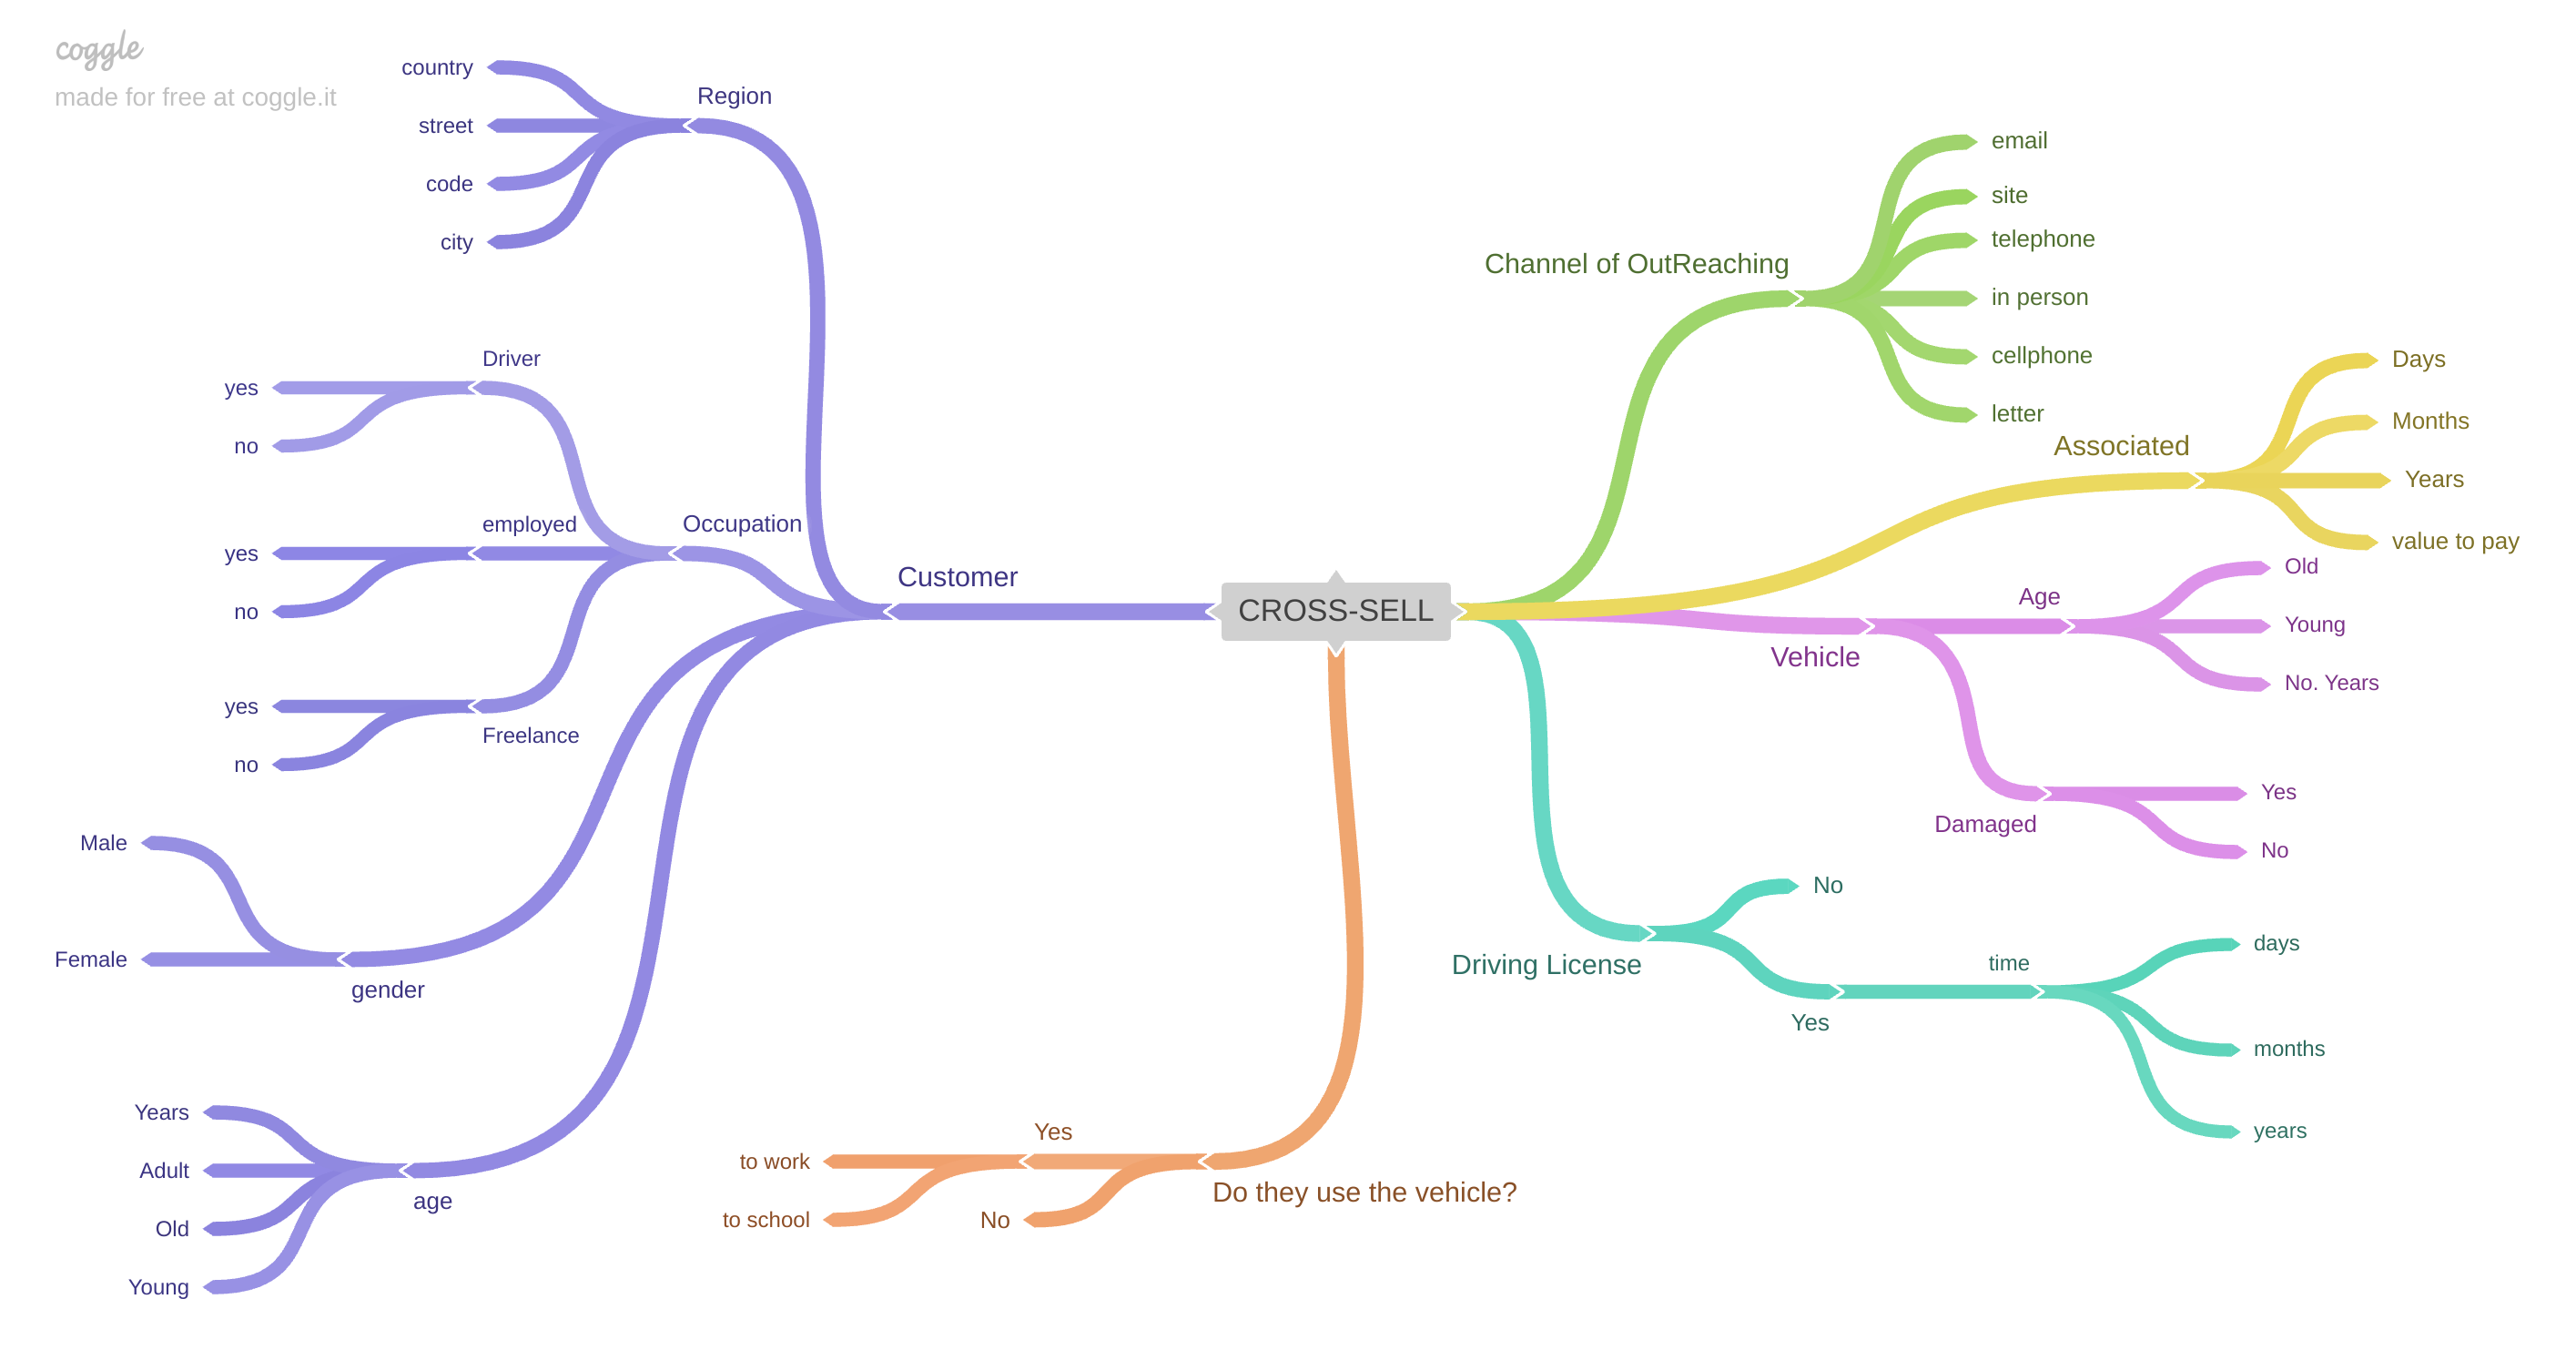

In [31]:
Image('/content/drive/MyDrive/cross_sell/CROSS_SELL_MindMap.png')

### **2.3 Hypothesis Creation**

#### **2.3.1 Customer**
* More than 60% of customers who want vehicle insurance are Man
* Young people account for less than 30% of customers who want vehicle insurance
* More than 80% of customeres who want vehicle insurance are the drivers?
* The older the customer, greater is the possibility of wanting vehicle insurance

#### **2.3.2 Vehicle**
* Customers with health insurance are more likely to get vehicle insurance
* 60% or more of the customers with one-two-year-old vehile are more likely pay for vehicle insurance
* Less than 40% of customers who have damaged the vehicle dont want to get the vehicle insurance


#### **2.3.3 Driving License**
* Most customer are licensed to drive
* Customers with more years licened to drive are more likely to pay for vehicle
* 60% or more of the customers with one or more years of driving license have vehicle damages


#### **2.3.4 Associated**
* Older customers and those which pay more for health insurance are more likely to get vehicle insurance
* 60% or less of the associated customeres are women



#### **2.3.5 Channel of OutReaching**
* 60% or more of the customers contacted by email are younger than 40 years
* The probability that telephone-contacted customers will purchase health insurance is 60% or less.



### **2.4 Selected Hyphothesis**
1. More than 60% of customers who want vehicle insurance are Man
2. Young people account for less than 30% of customers who want vehicle insurance
3. The older the customer, greater is the possibility of wanting vehicle insurance
4. Customers with health insurance are more likely to get vehicle insurance
5. 60% or more of the customers with one-two-year-old vehile are more likely pay for vehicle insurance
6. Over 70% of customers who are want to purchase vehicle insurance had damaged vehicles
7. Older customers and those which pay more for health insurance are more likely to get vehicle insurance

### **2.5 Feature Engineering**

In [32]:
## life stage
df2['life_stage'] = df2['Age'].apply(getLifeStage)
df2.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,life_stage
0,Male,44,yes,28.0,no,> 2 Years,yes,40454.0,26.0,217,yes,Midlife
1,Male,76,yes,3.0,no,1-2 Year,no,33536.0,26.0,183,no,Mature Adulthood
2,Male,47,yes,28.0,no,> 2 Years,yes,38294.0,26.0,27,yes,Midlife
3,Male,21,yes,11.0,yes,< 1 Year,no,28619.0,152.0,203,no,Early Adulthood
4,Female,29,yes,41.0,yes,< 1 Year,no,27496.0,152.0,39,no,Early Adulthood


### **2.6 Save**

In [33]:
df2.to_csv('/content/drive/MyDrive/cross_sell/data_step02_cycle1.csv',index=False)

## **3.0 Filtering Variables**

### **3.1 Loading**

In [34]:
df3 = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step02_cycle1.csv")

### **3.2 Filtering Lines**
There's no lines to be dropped from the dataset for data analysis

### **3.3 Filtering Columns**
There's no columns to drop

### **3.4 Saves**


In [35]:
df3.to_csv("/content/drive/MyDrive/cross_sell/data_step03_cycle1.csv",index= False)

## **4.0 EDA**
### **4.1 Loading**

In [36]:
df4 = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step03_cycle1.csv")

### **4.2 Univariate Analysis**
#### **4.2.1 Response Variable**


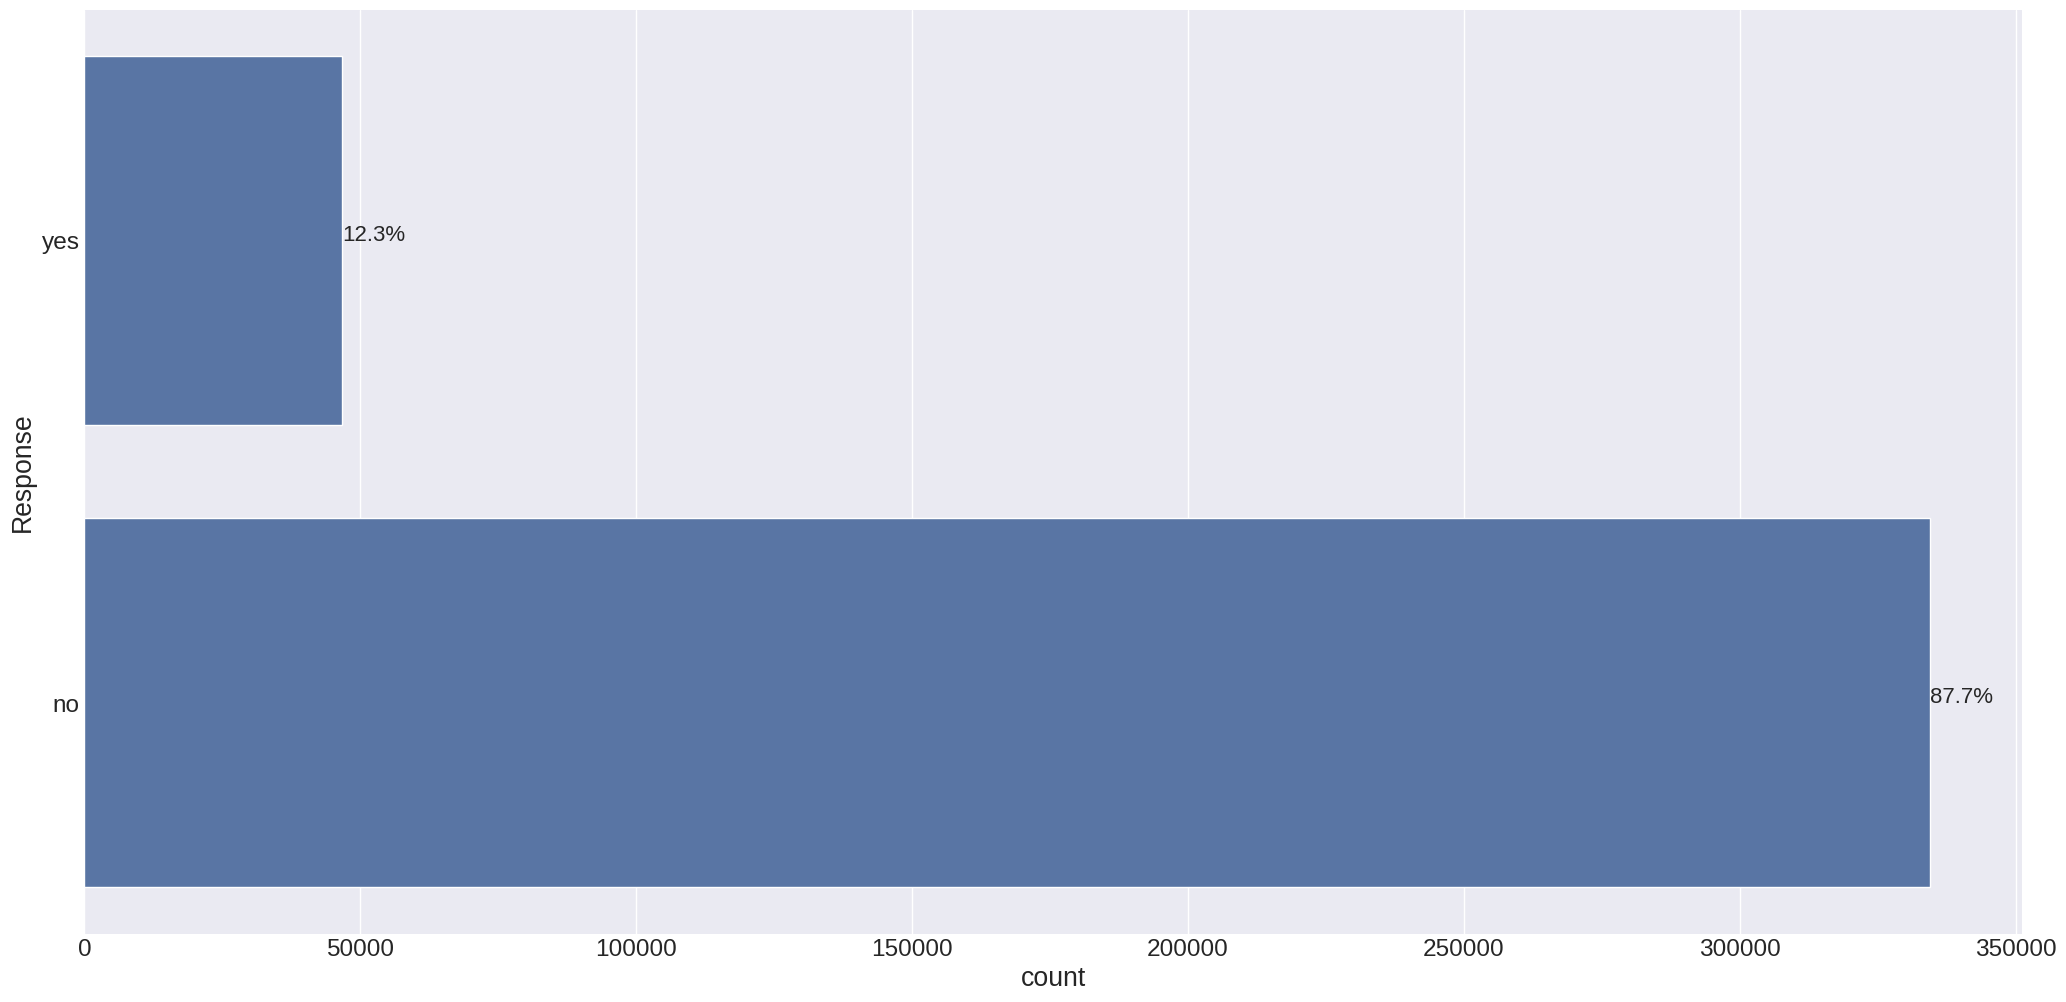

In [37]:
ax = sns.countplot(y='Response',data= df4)

total = df4['Response'].size
for p in ax.patches:
  percentage = '{:.1f}%'.format(100*p.get_width()/total)
  x = p.get_x() + p.get_width() +0.02
  y = p.get_y() + p.get_height()/2
  ax.annotate(percentage,(x,y))



#### **4.2.2 Numerical Variable**

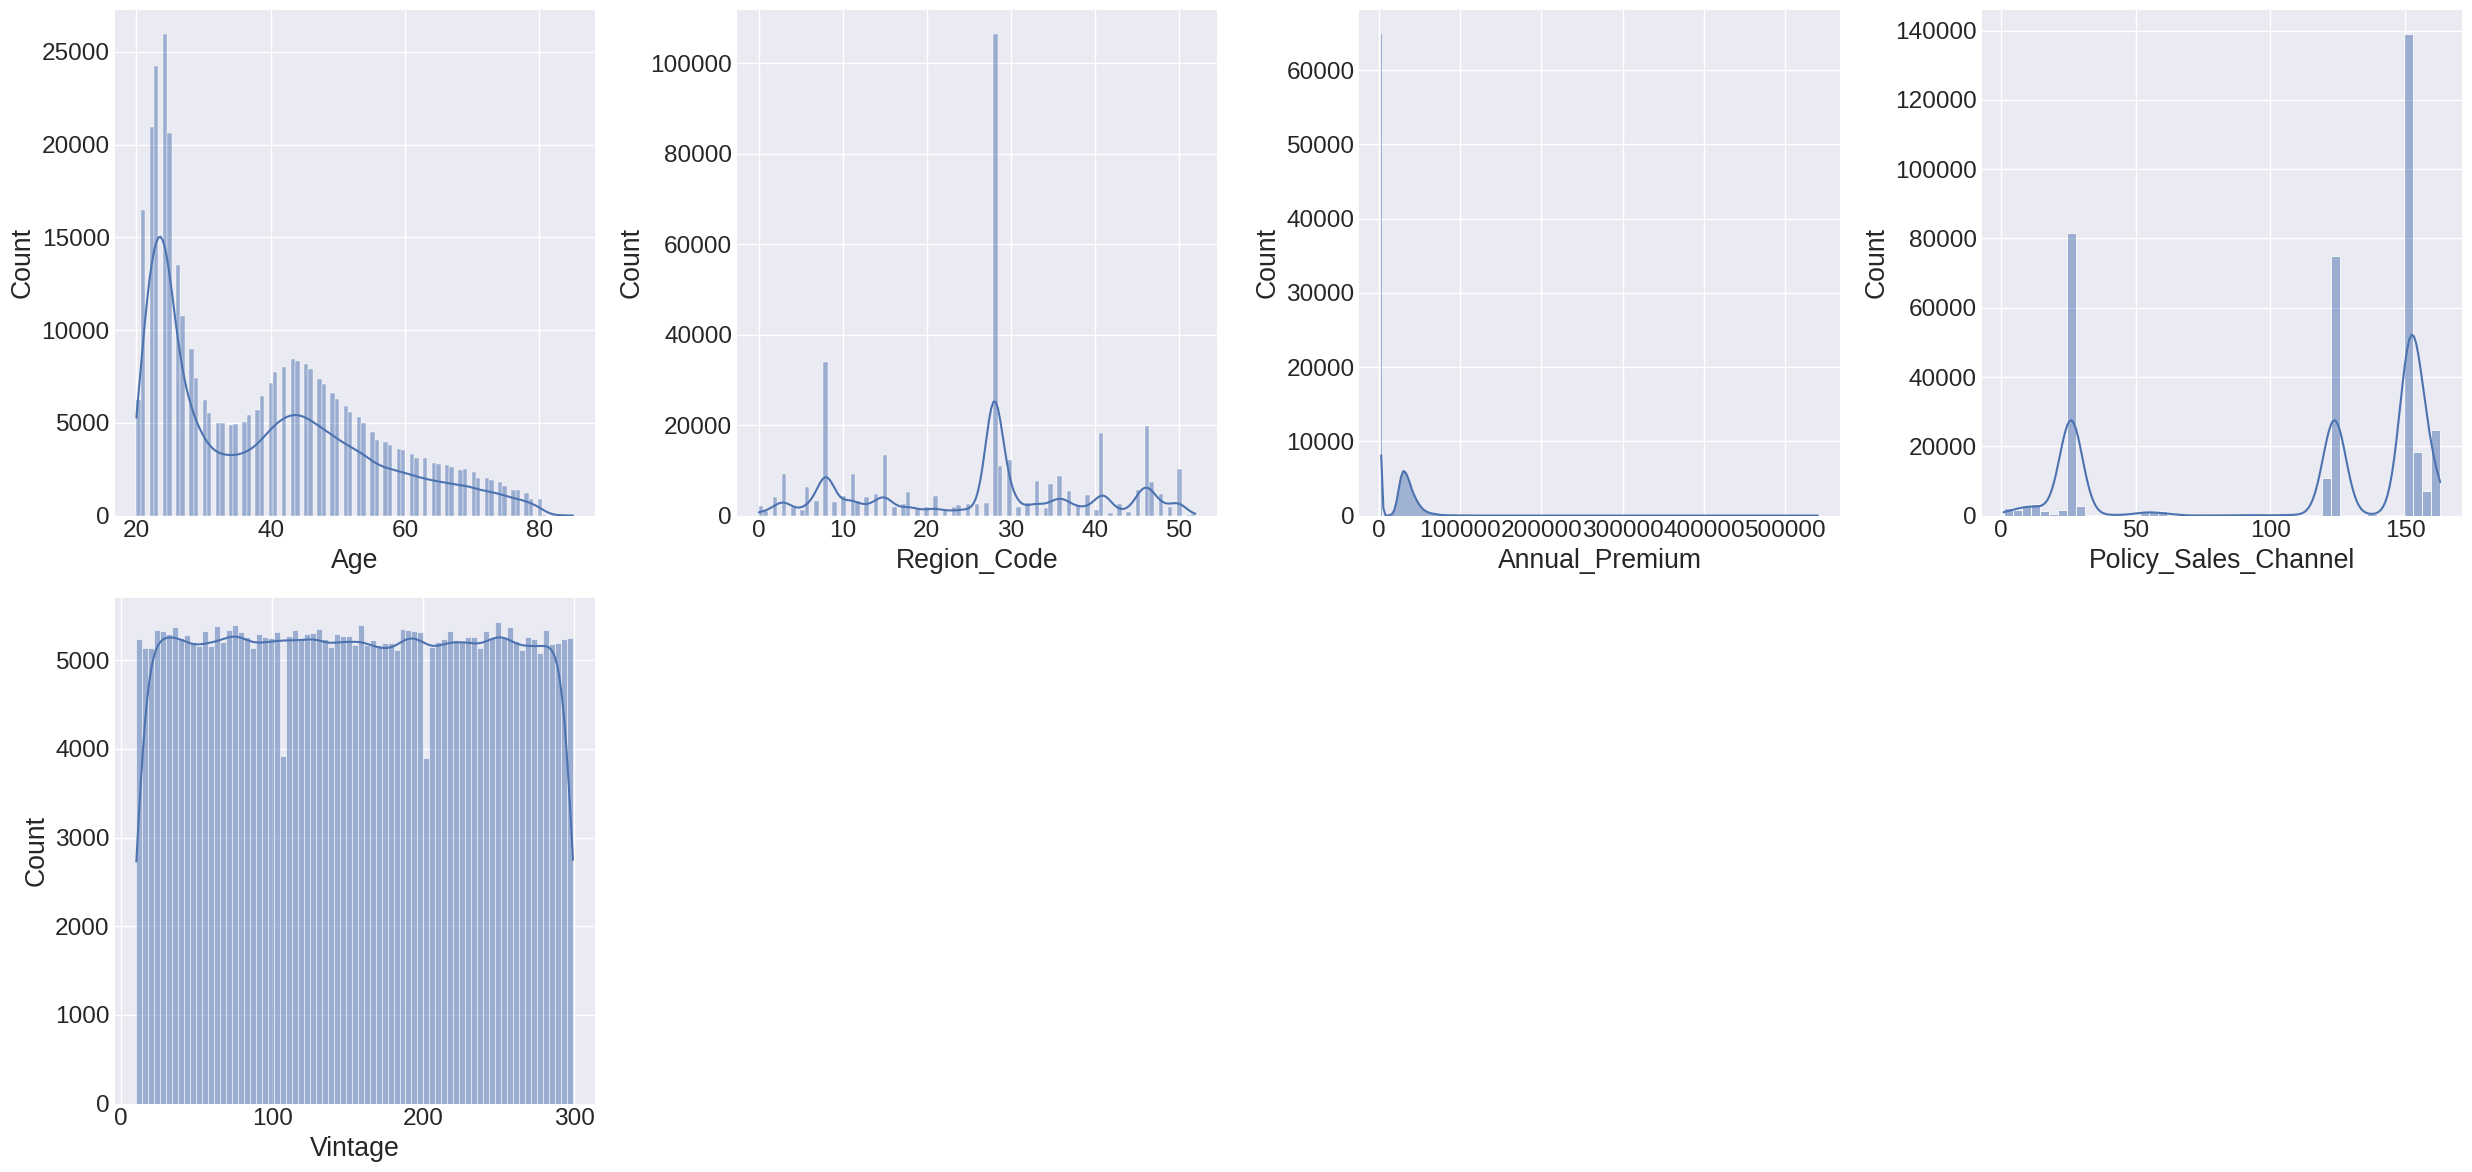

In [38]:
aux1 = df4.select_dtypes(exclude='object')
columns = aux1.columns.to_list()
j=1

for col in columns:
  plt.subplot(2,4,j)
  sns.histplot(aux1[col], kde=True)
  j+=1

plt.tight_layout()

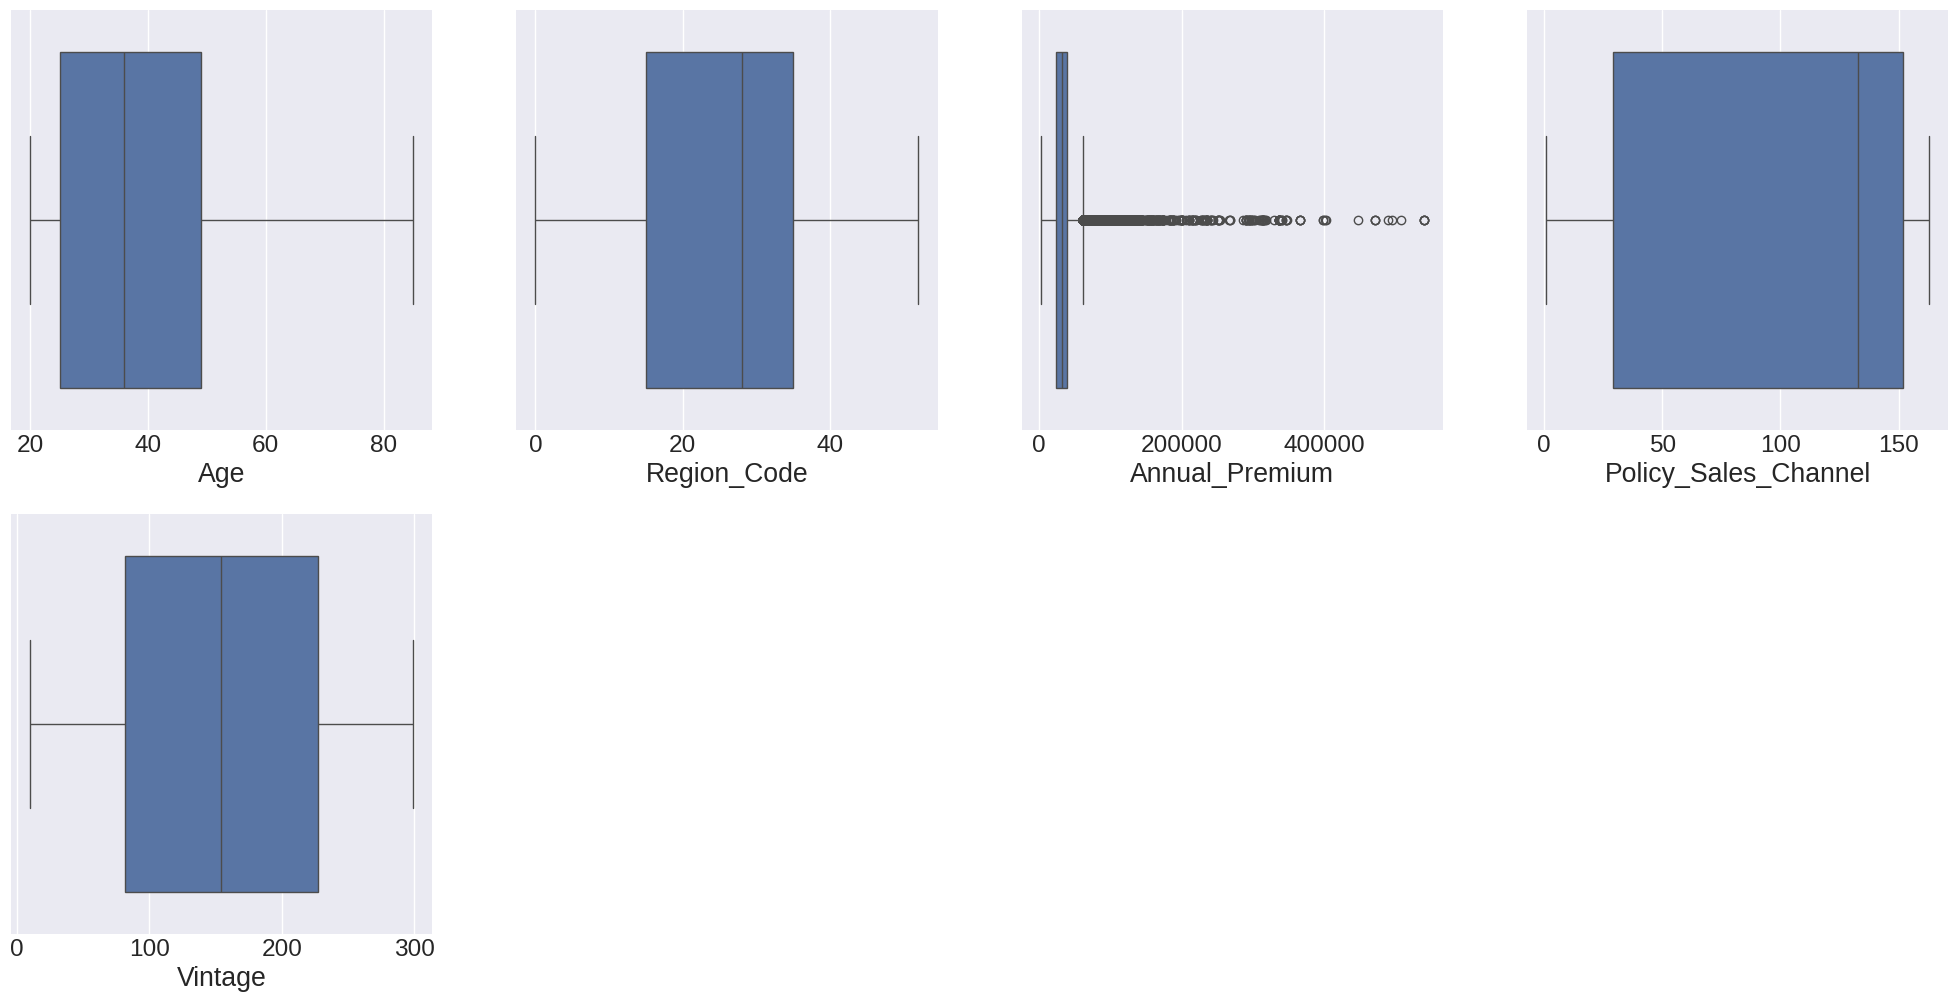

In [39]:
j=1
for col in columns:
  plt.subplot(2,4,j)
  sns.boxplot(x = aux1[col])
  j+=1


#### **4.2.3 Categorical Variables**

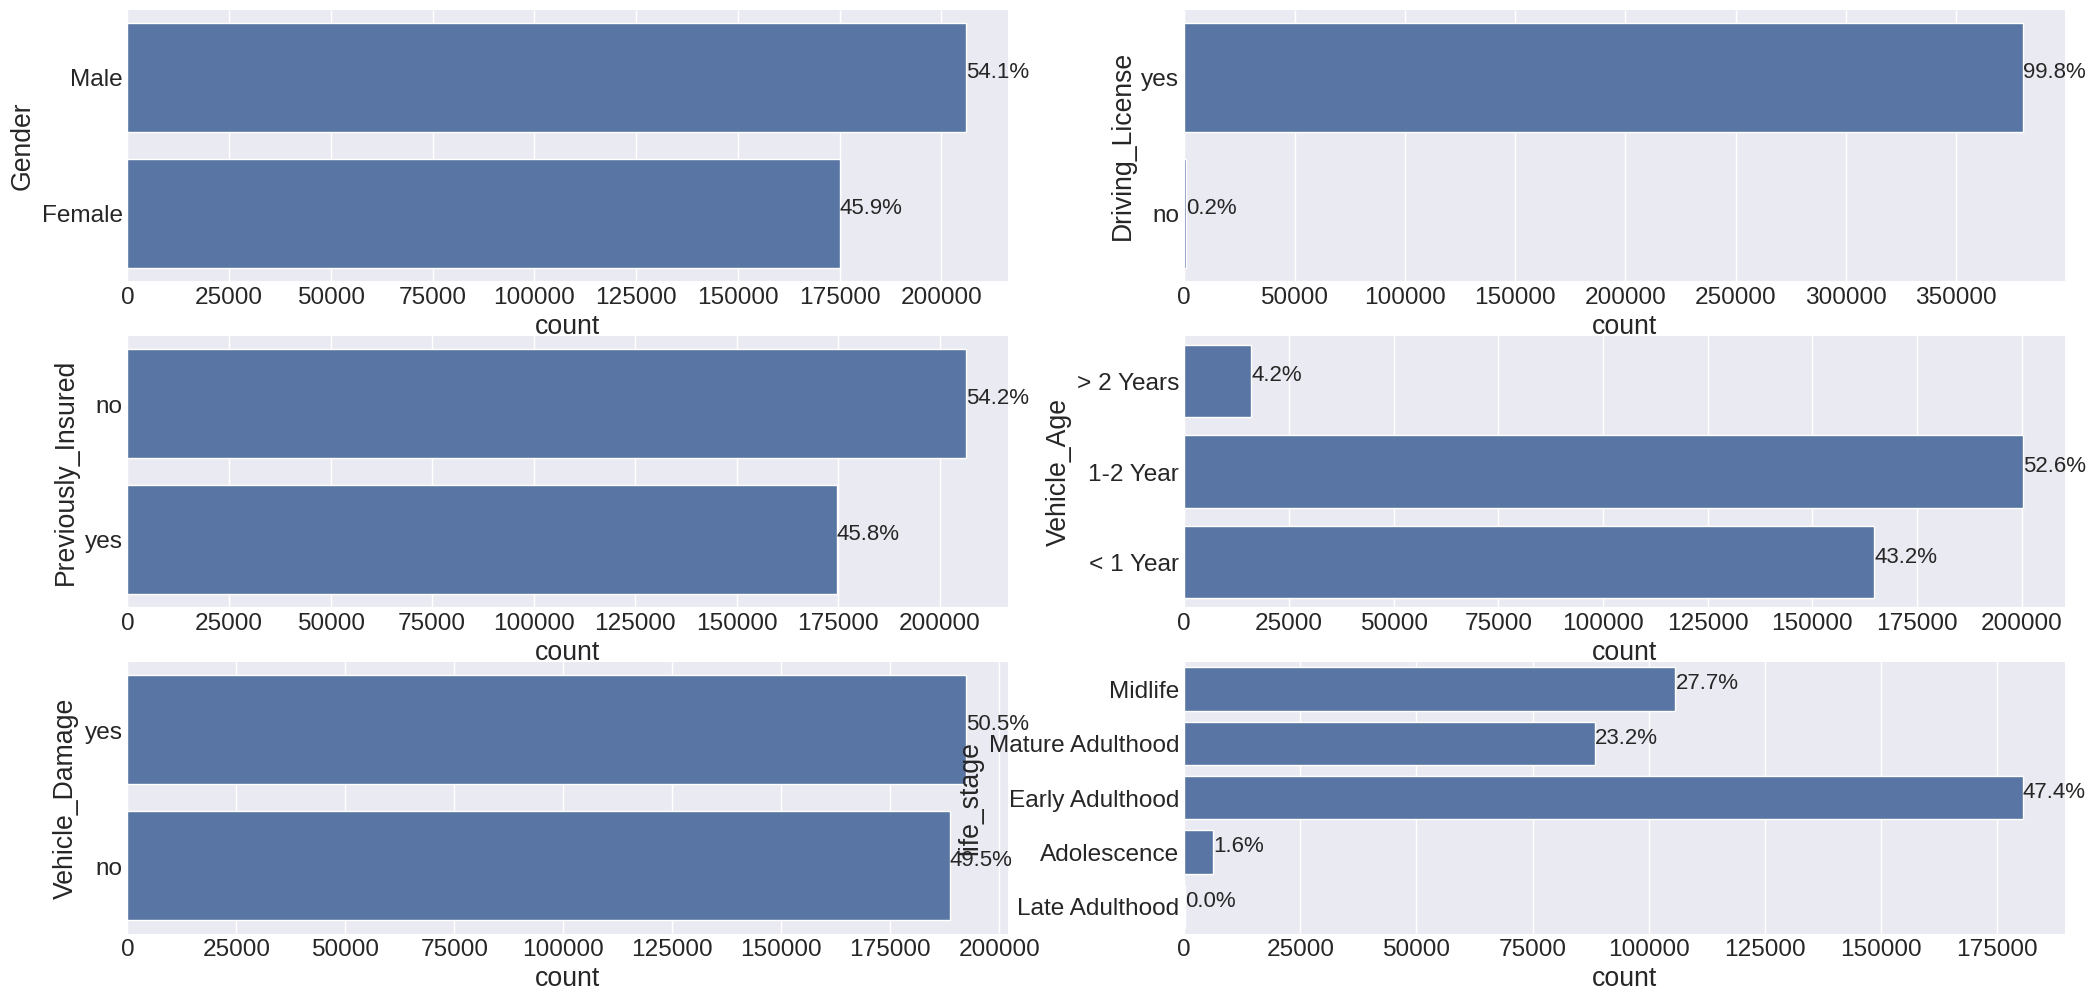

In [40]:
aux1 = df4.drop(columns = ['Response'],axis=1).select_dtypes(include='object')
columns = aux1.columns.to_list()
j=1
for col in columns:
  plt.subplot(3,2,j)
  ax = sns.countplot(y=col,data=aux1)
  total = aux1[col].size
  for p in ax.patches:
    percentage = '{:.1f}%'.format(100*p.get_width()/total)
    x = p.get_x() + p.get_width() +0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage,(x,y))
  j+=1

### **4.3 Bivariate Analysis**

**H1  More than 60% of customers who want vehicle insurance are Men**

True: It's true, because basically men drive more than women. Among customers who want insurance, there are 20% fewer women than men

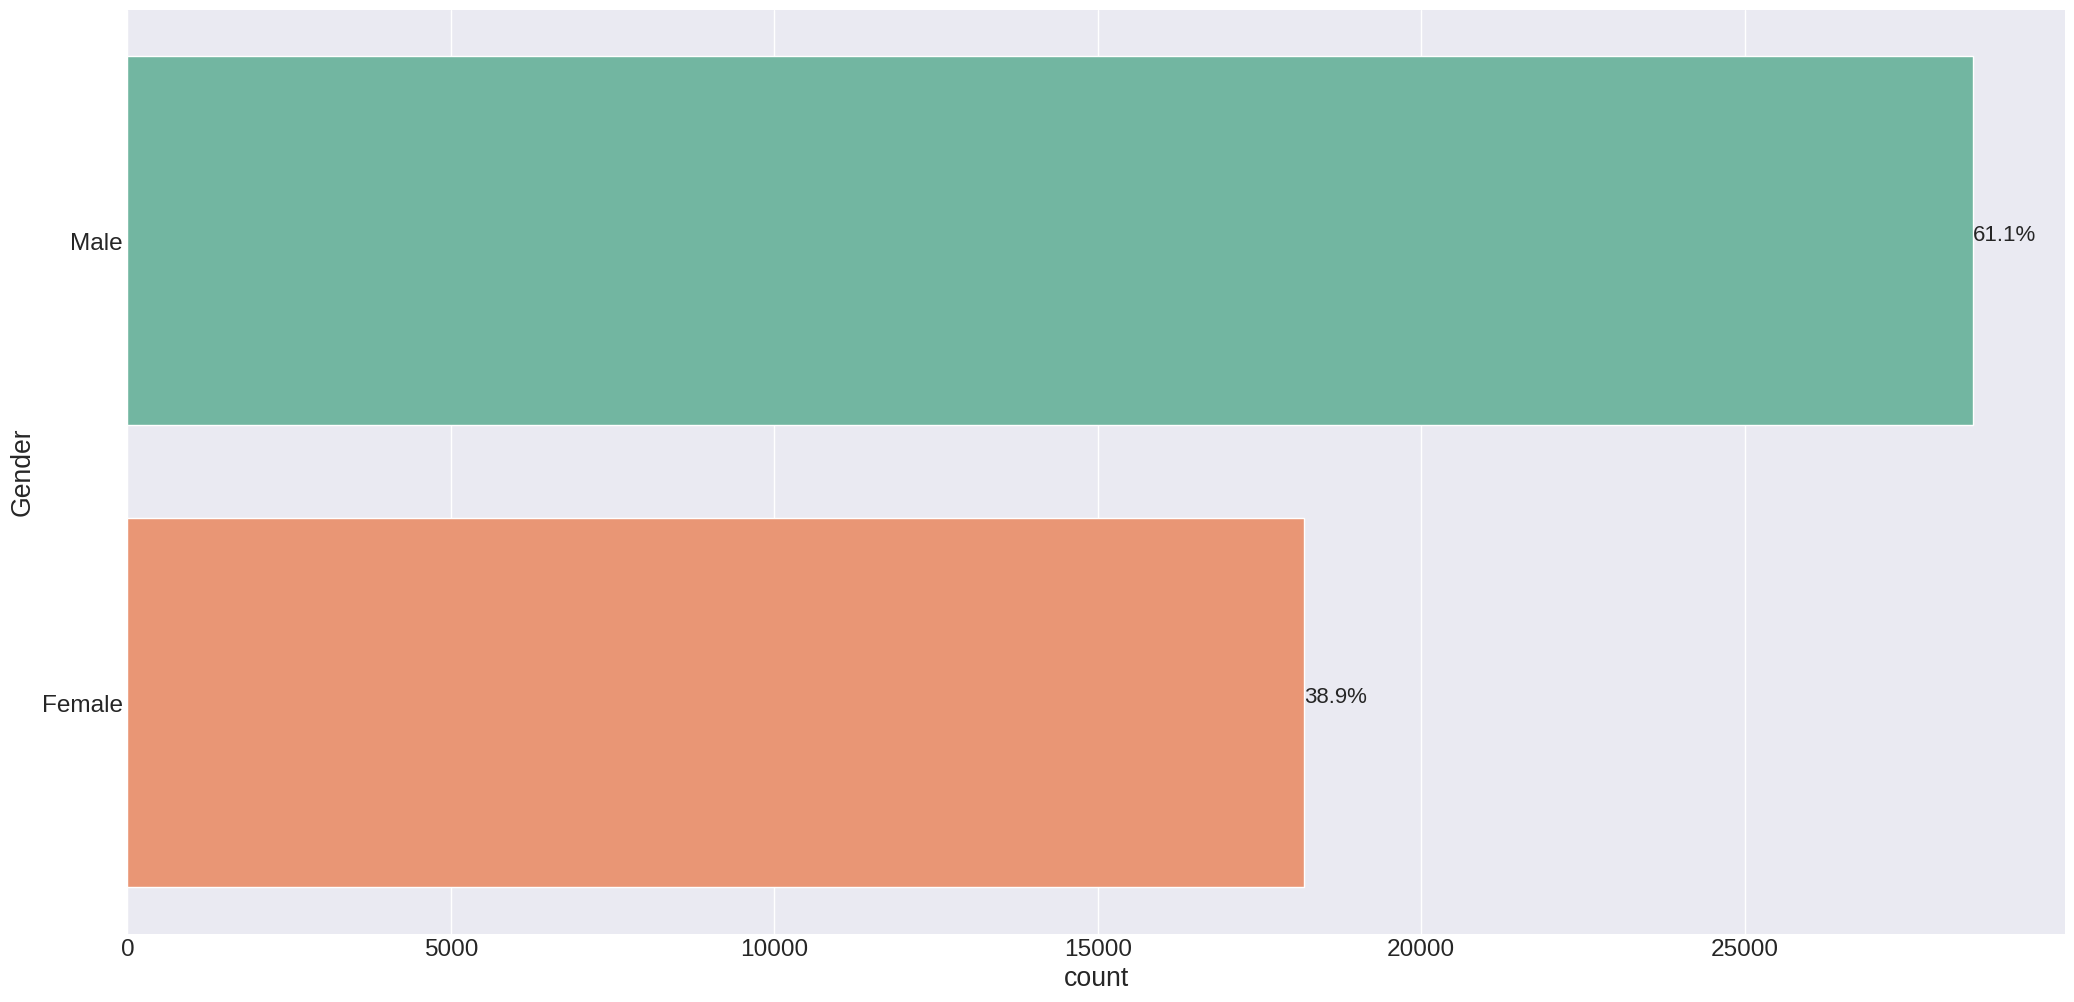

In [41]:
aux1= df4[df4['Response']=='yes']

ax = sns.countplot(y='Gender',data = aux1, palette=sns.color_palette("Set2", n_colors=aux1['Gender'].nunique()))

total = aux1['Gender'].size
for p in ax.patches:
  percentage = '{:.1f}%'.format(100*p.get_width()/total)
  x = p.get_x() + p.get_width() +0.02
  y = p.get_y()+ p.get_height()/2
  ax.annotate(percentage,(x,y))

**H2. Young people account for less than 30% of customers who want vehicle insurance**

**TRUE:** Early Aulthood and adolescent are about 26.1% of the cutomer who want the vehicle insurance. The midlife customers are more likely to get insurance, they are about 48.3%

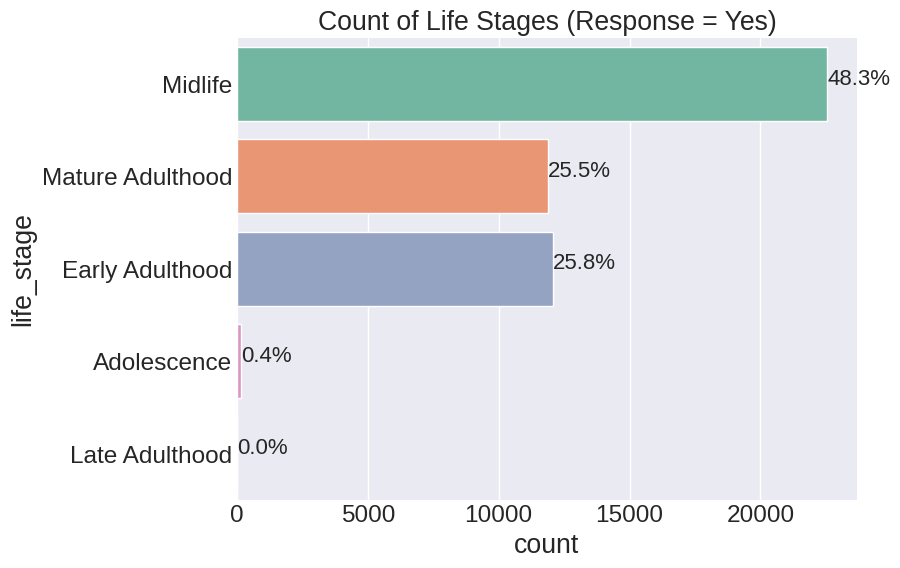

In [42]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='life_stage',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['life_stage'].nunique())
)

total = aux1['Gender'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Life Stages (Response = Yes)")
plt.show()

**H3. The older the customer, greater is the possibility of wanting vehicle insurance**

**FALSE** Although young customers account for the majority, but they aren't the group customer with the highest likelihood of wanting vehicle insurance. People who want insrance are in between 40 and 50 years old.

<Axes: xlabel='Age', ylabel='Density'>

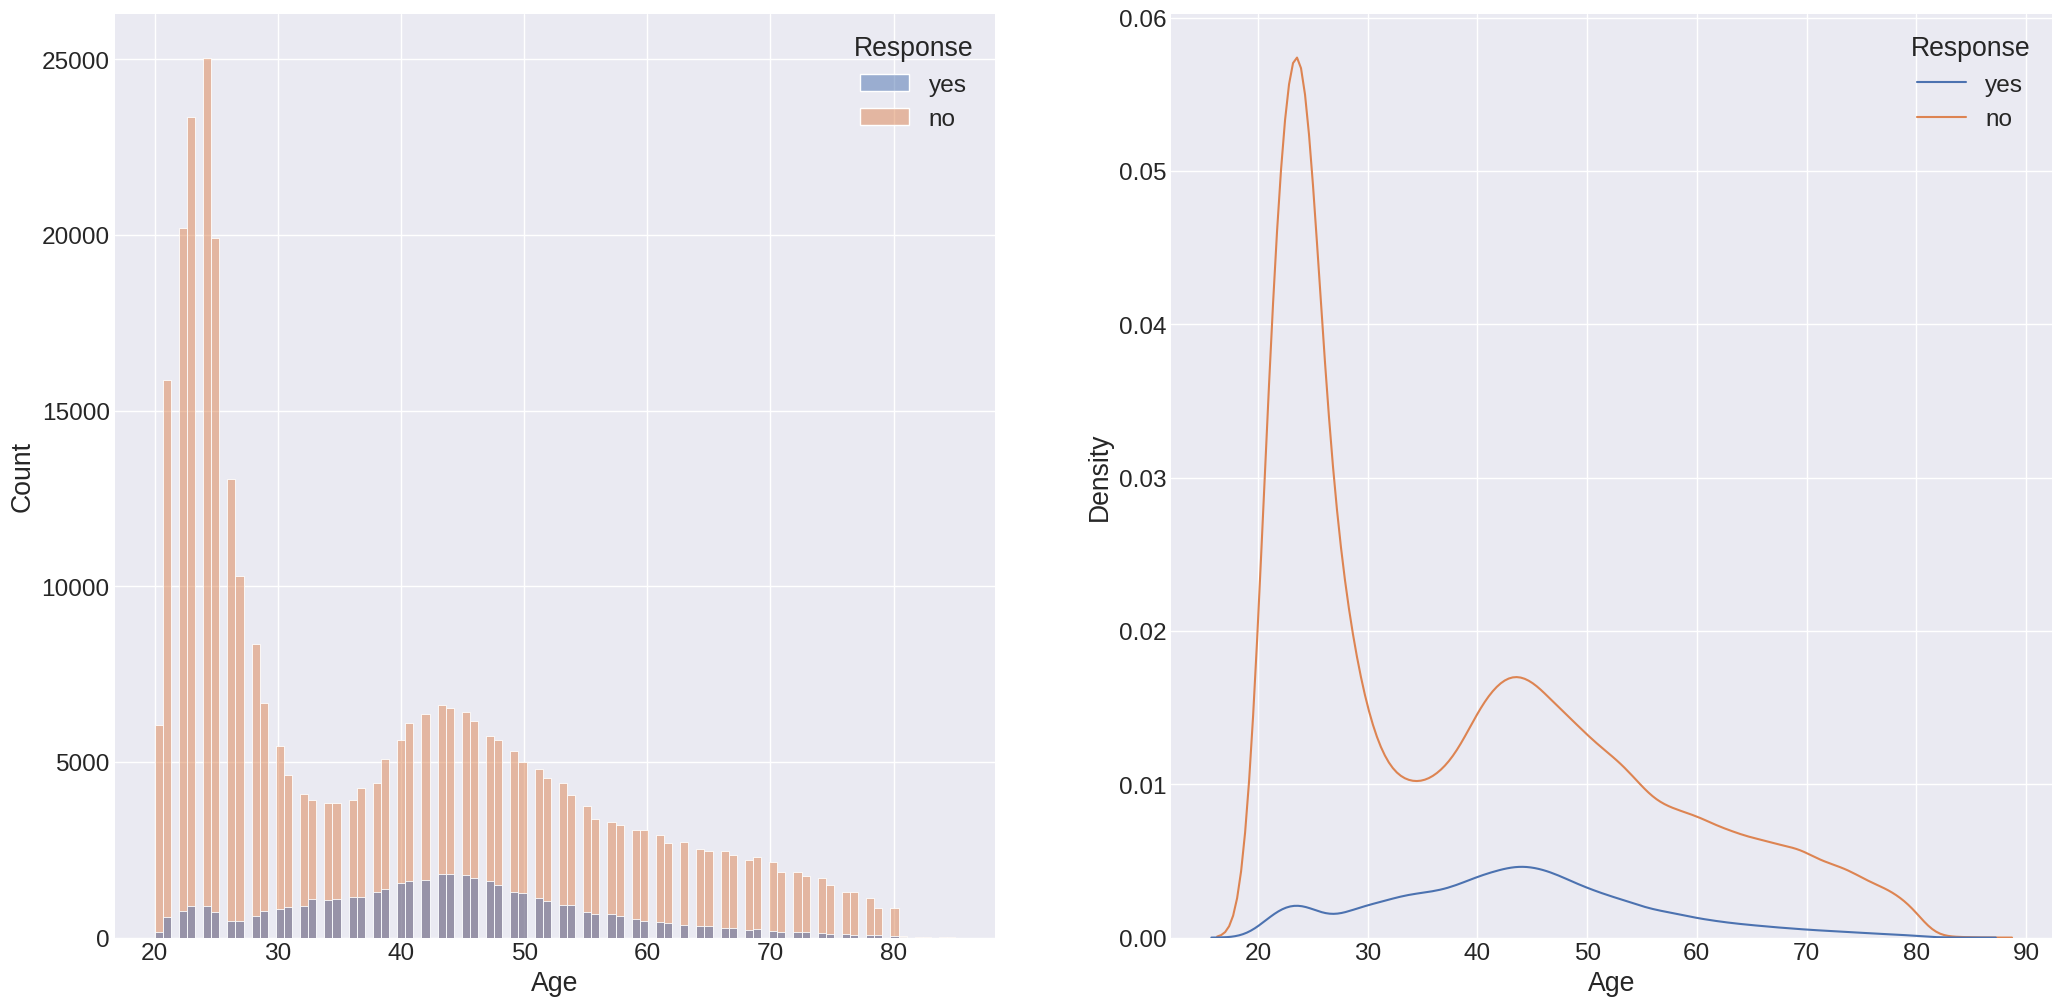

In [43]:
plt.subplot(1,2,1)
sns.histplot(x='Age',data = df4, hue ='Response')
plt.subplot(1,2,2)
sns.kdeplot(x='Age',data = df4, hue ='Response')

**H4. Customers with health insurance are more likely to get vehicle insurance**

I will take a statistical hypothesis test
* H0(null hypothesis): Having previously held health insurance does not impact the likelihood of purchasing vehicle insurance
* H1(Alternative hyposthesis): A significant relationship between having health insurance and the likelihood of purchasing vehicle insurance.

--> There is a significant relationship between having health insrance and the likelihood of purchasing vehicle insrance , but not as we think: customers with health insurance are more likely to buy vehicle insurance. It seems that when customers have previously purchased health insurance, they are less inclined to buy vehicle insurance.

In [44]:
cross_tab = pd.crosstab(df4['Previously_Insured'], df4['Response'])
cross_tab
prob_vehicle_given_health_yes = cross_tab.loc['yes','yes']/cross_tab.loc['yes'].sum()
prob_vehicle_given_health_no = cross_tab.loc['no','yes']/cross_tab.loc['no'].sum()
print("P(Vehicle=Yes | Health=Yes):", prob_vehicle_given_health_yes)
print("P(Vehicle=Yes | Health=No):", prob_vehicle_given_health_no)

from scipy.stats import chi2_contingency


chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-squared:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)


if p < 0.05:
    print("Conclusion: Have a relationship between having health insurance and the likelihood of purchasing vehicle insurance.")
else:
    print("Conclusion: There isn't any relationship between them.")


P(Vehicle=Yes | Health=Yes): 0.0009047804475799987
P(Vehicle=Yes | Health=No): 0.22545415800969582
Chi-squared: 44357.96472219977
p-value: 0.0
Degrees of Freedom: 1
Conclusion: Have a relationship between having health insurance and the likelihood of purchasing vehicle insurance.


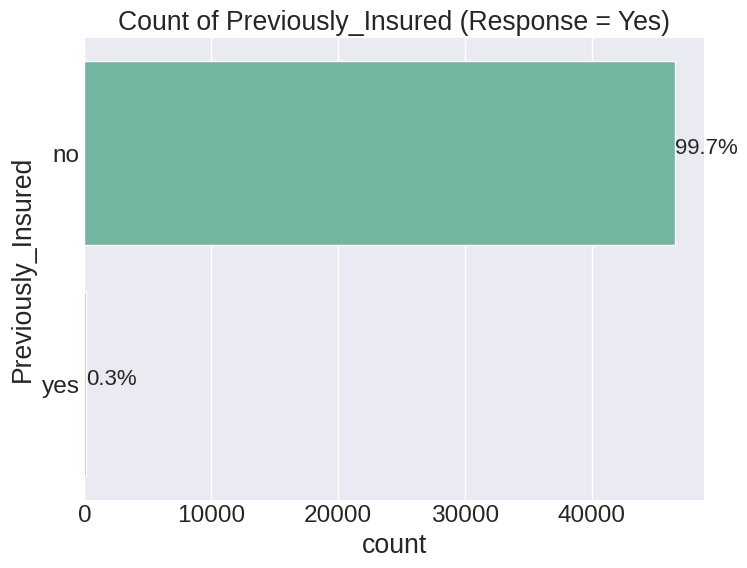

In [45]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Previously_Insured',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Previously_Insured'].nunique())
)

total = aux1['Previously_Insured'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Previously_Insured (Response = Yes)")
plt.show()

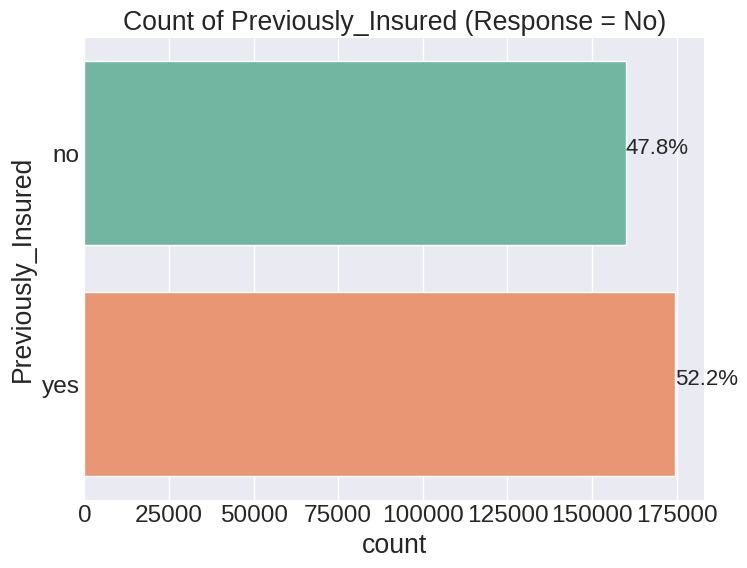

In [46]:
aux1= df4[df4['Response']=='no']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Previously_Insured',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Previously_Insured'].nunique())
)

total = aux1['Previously_Insured'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Previously_Insured (Response = No)")
plt.show()

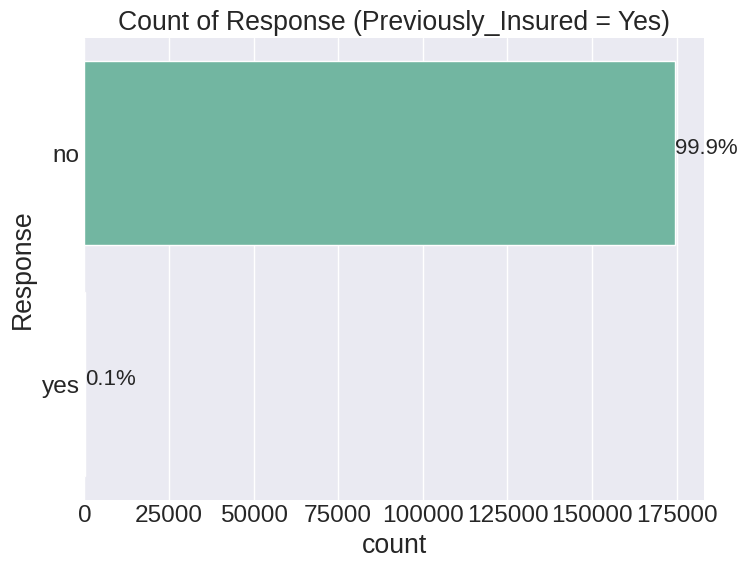

In [47]:
aux1= df4[df4['Previously_Insured']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Response',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Response'].nunique())
)

total = aux1['Response'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Response (Previously_Insured = Yes)")
plt.show()

**H5 60% or more of the customers with one-two-year-old vehile are more likely pay for vehicle insurance**

Customers with vehicle between one and two years are about 74.5%. The main reason is that most customers have owned their vehicle for about 1-2 years


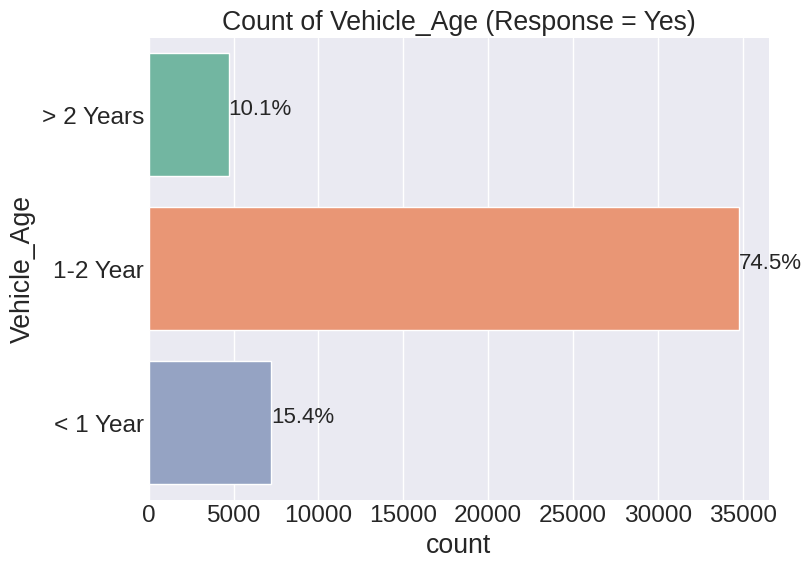

In [48]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Vehicle_Age',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Vehicle_Age'].nunique())
)

total = aux1['Vehicle_Age'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Vehicle_Age (Response = Yes)")
plt.show()

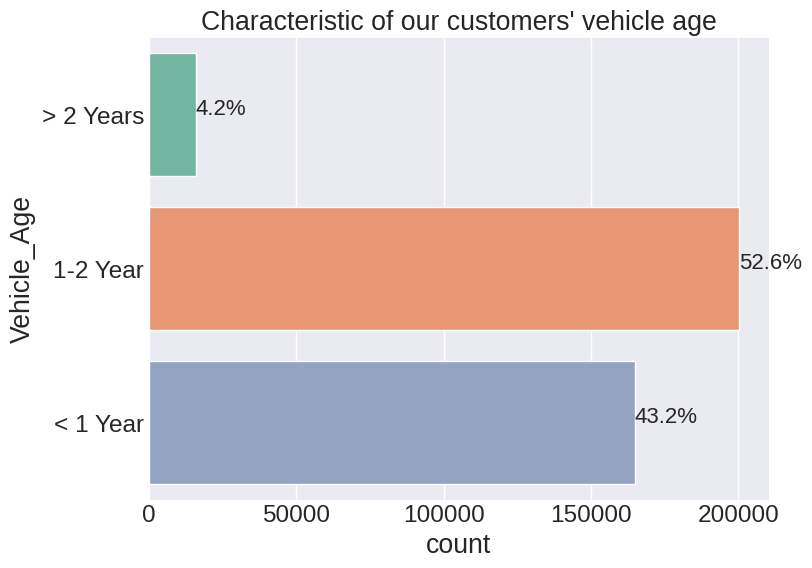

In [49]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Vehicle_Age',
    data=df4,
    palette=sns.color_palette("Set2", n_colors=aux1['Vehicle_Age'].nunique())
)

total = df4['Vehicle_Age'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))
plt.title("Characteristic of our customers' vehicle age")
plt.show()

**H6 Over 70% of customers who are want to purchase vehicle insurance had damaged vehicles.**

TRUE: 97.9% of customers who are interested in purchasing vehicle insurance had previously experienced vehicle damage.


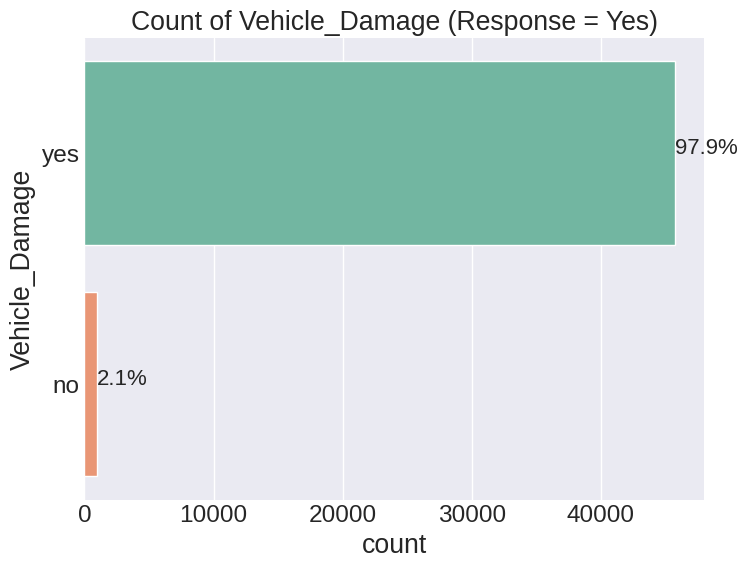

In [50]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Vehicle_Damage',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Vehicle_Damage'].nunique())
)

total = aux1['Vehicle_Damage'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Vehicle_Damage (Response = Yes)")
plt.show()

**H7 Older customers and those which pay more for health insurance are more likely to get vehicle insurance.**

There's no different for older customers who pay for annual premium.

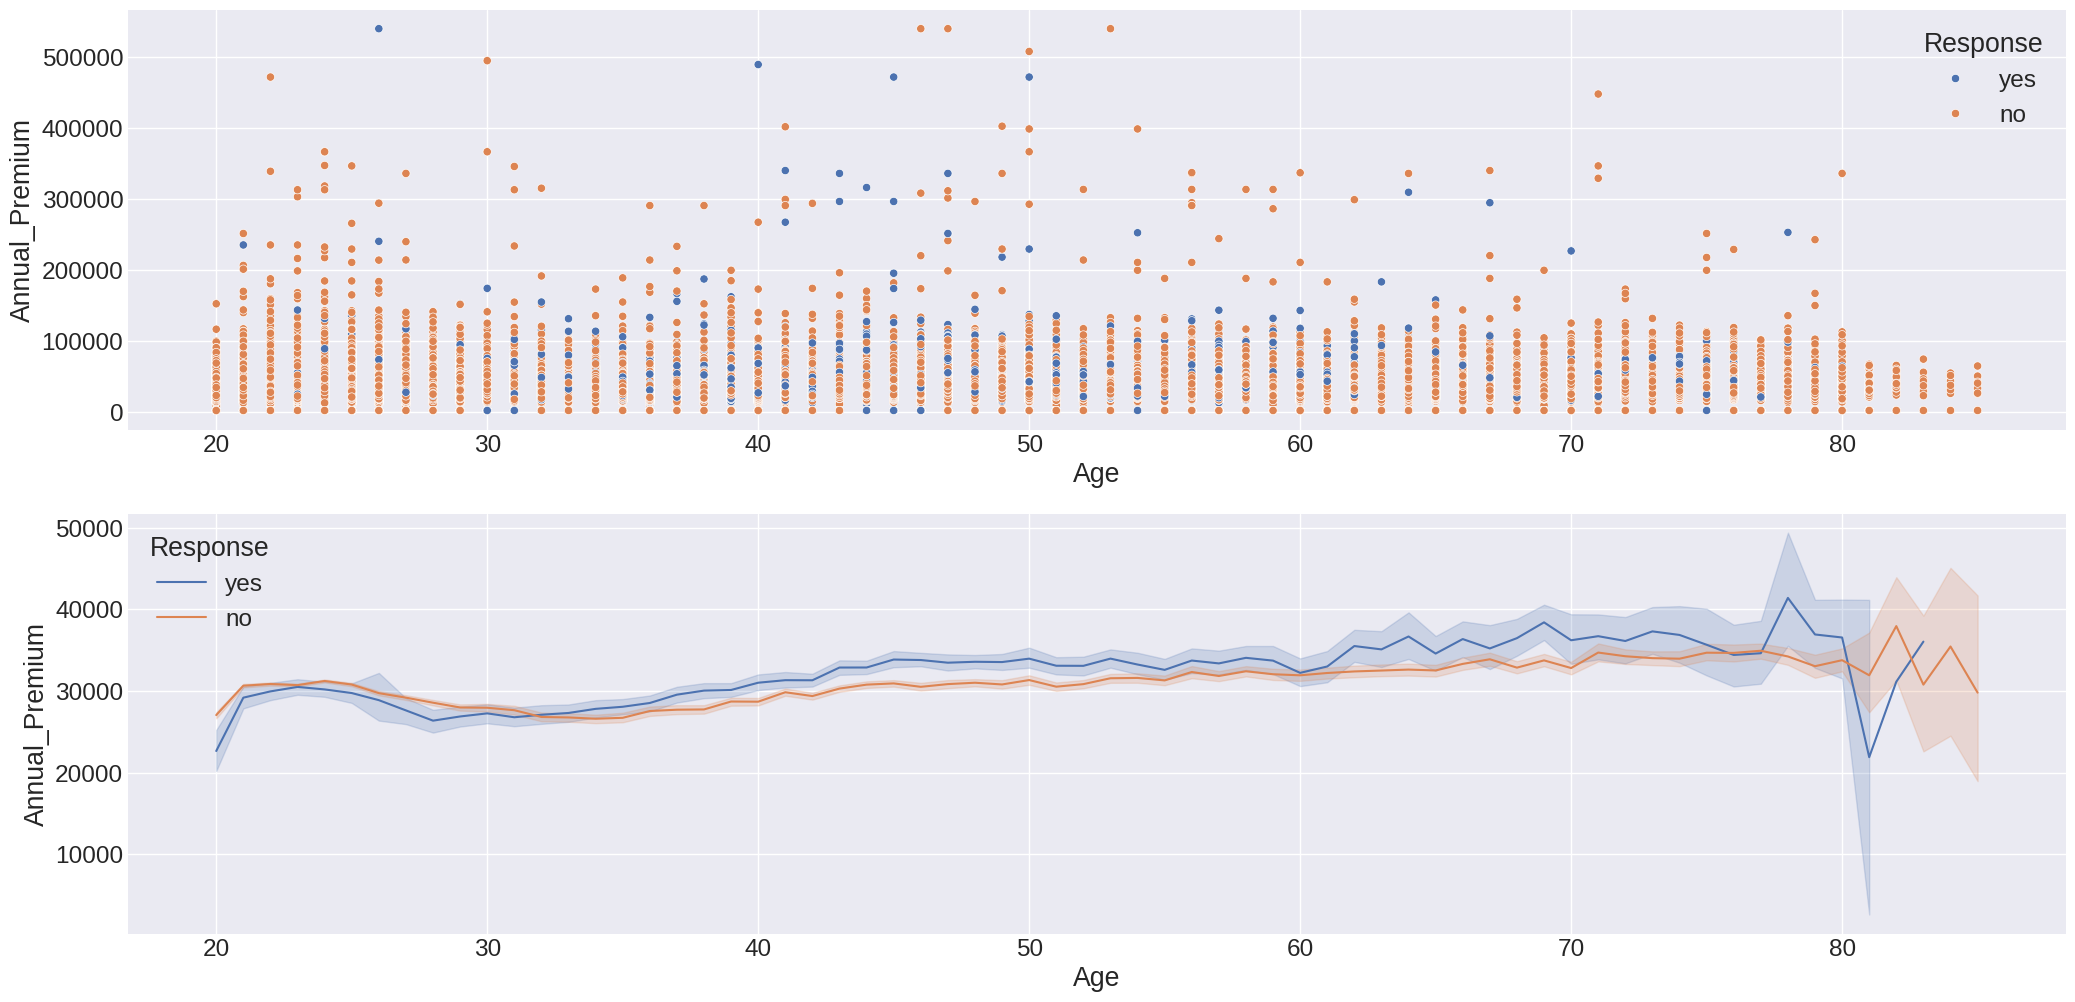

In [51]:
plt.subplot(2, 1, 1)
sns.scatterplot(x='Age', y='Annual_Premium', data=df4, hue='Response')

plt.subplot(2, 1, 2)
sns.lineplot(x='Age', y='Annual_Premium', data=df4, hue='Response');


### **4.4 Multivariaty Analysis**
####**4.4.1 Numerical**

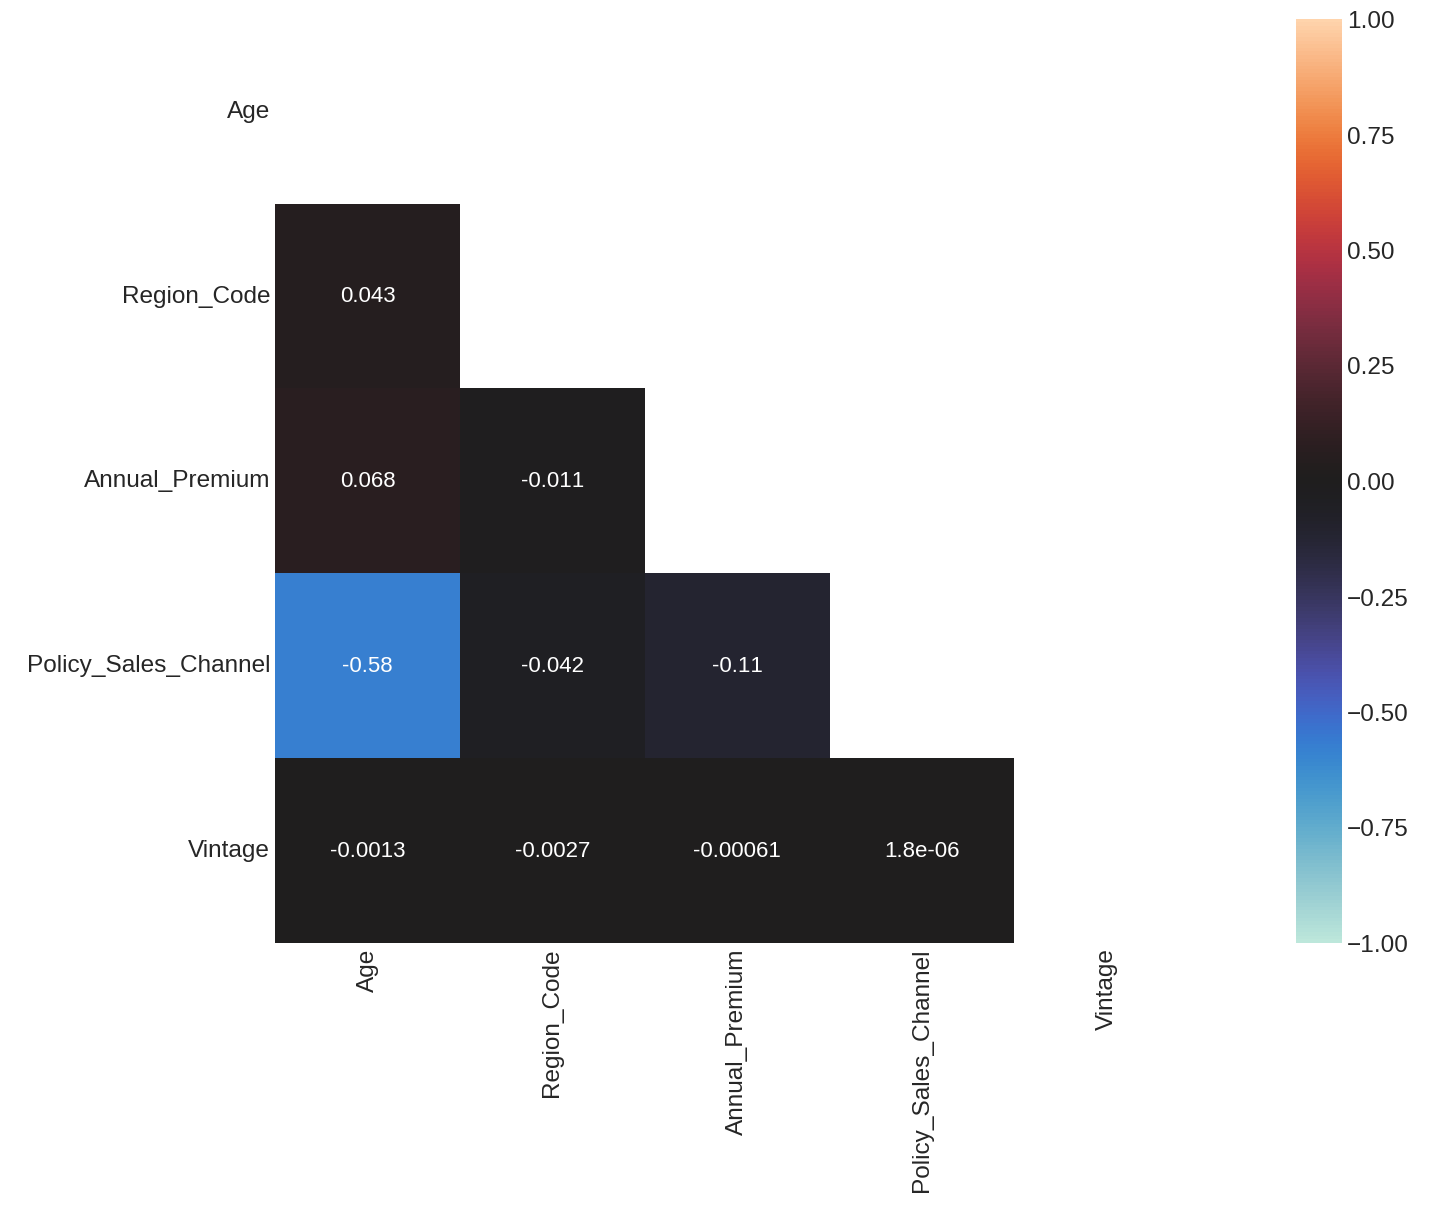

In [52]:
corr = aux1 = df4.select_dtypes(exclude='object').corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

There isn't any relationship

####**4.4.2 Categorical**

In [53]:
cat_attributes = df4.select_dtypes(include='object')
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}

    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

corr = pd.DataFrame(dict_corr)



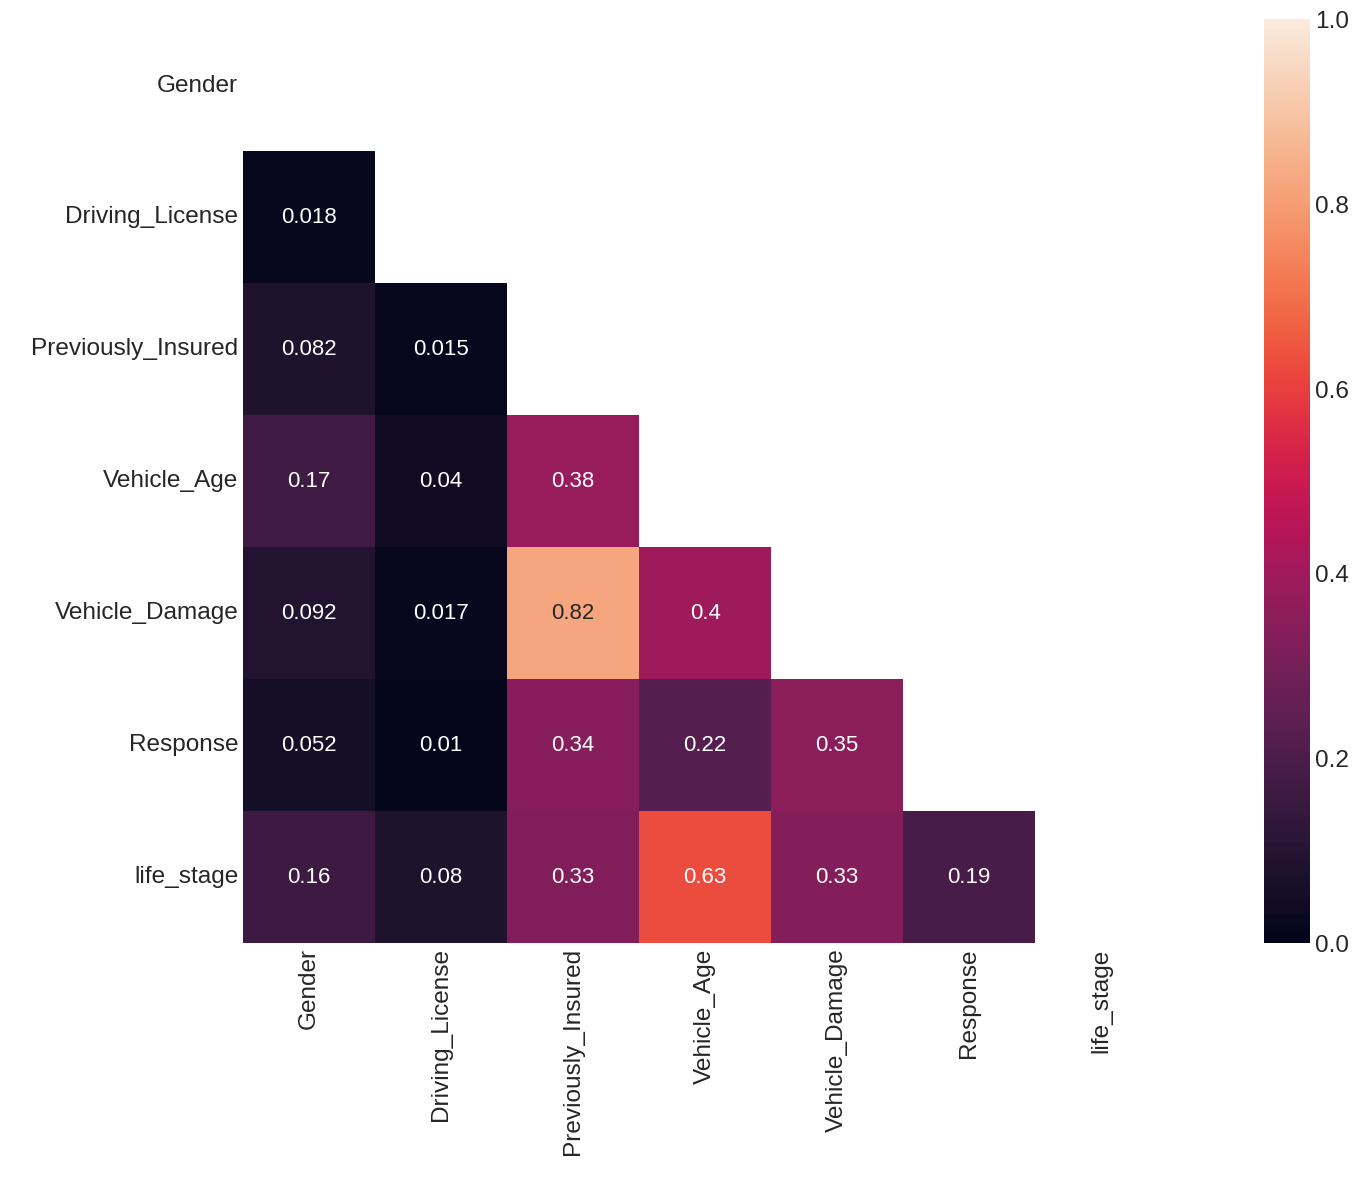

In [54]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

## **5.0 Data Preparation**

### **5.1 Loading**

In [55]:
df5 = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step03_cycle1.csv")

### **5.2 Spliting into Train, Valid and Test**

In [56]:
X = df5.drop(columns=['Response'],axis=1)
y = df5['Response'].map({'yes':1,'no':0})

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp)

### **5.3 Categorical Encoder**
#### **5.3.1 One Hot Encoder**

In [57]:
ohe_columns = ['Gender', 'Previously_Insured', 'Driving_License', 'Vehicle_Damage']
ohe = ce.OneHotEncoder(cols=ohe_columns, use_cat_names=True)


In [58]:
X_params = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)


In [59]:
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

#### **5.3.2 Ordinal Encoder**

In [60]:
columns_to = ['Vehicle_Age','life_stage' ]
oe = ce.OrdinalEncoder(cols=columns_to,
                       mapping=[
                           {'col': 'Vehicle_Age',
                            'mapping': {'< 1 Year': 1,
                                        '1-2 Year': 2,
                                        '> 2 Years': 3}
                           },
                           {'col': 'life_stage',
                            'mapping': {'Adolescence': 4,
                                        'Early Adulthood': 5,
                                        'Midlife': 6,
                                        'Mature Adulthood': 7,
                                        'Late Adulthood': 8}
                           }
                       ], return_df=False)

columns_to_oe = list(map(lambda i: i + '_oe', columns_to))

X_params[columns_to_oe] = oe.fit_transform(X_params[columns_to])
X_test[columns_to_oe] = oe.transform(X_test[columns_to])

X_train[columns_to_oe] = oe.fit_transform(X_train[columns_to])
X_valid[columns_to_oe] = oe.transform(X_valid[columns_to])

#### **5.3.3 Target Encoder**

In [61]:
columns_to = ['Region_Code', 'Policy_Sales_Channel', 'Vehicle_Age', 'life_stage']
te = ce.TargetEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_te', columns_to))

X_params[columns_to_te] = te.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = te.transform(X_test[columns_to])

In [62]:
X_train[columns_to_te] = te.fit_transform(X_train[columns_to], y_train)
X_valid[columns_to_te] = te.transform(X_valid[columns_to])


#### **5.3.4 Count Encoder**

In [63]:
columns_to = ['Region_Code', 'Policy_Sales_Channel', 'Vehicle_Age', 'life_stage']
count = ce.CountEncoder(cols=columns_to, return_df=False)

columns_to_te = list(map(lambda i: i + '_ce', columns_to))

X_params[columns_to_te] = count.fit_transform(X_params[columns_to], y_temp)
X_test[columns_to_te] = count.transform(X_test[columns_to])

### **5.4 Natural Transformation**

#### **5.4.1 Age**

In [64]:
X_params['Age'].head()

,Age
274710,22
216539,26
78983,32
218368,32
307215,24


In [65]:
normal_tests(X_params['Age'])

,Shapiro,Skew,Kurtosis
Original,0.909740,0.671706,-0.568536
Boxcox,0.933842,0.062228,-1.348094
Square Root,0.927860,0.425563,-0.987972
Cube Root,0.930823,0.348966,-1.090802
Log,0.933749,0.204254,-1.246811


In [66]:
X_params['age_bx']= stats.boxcox(X_params['Age'])[0]
X_test['age_bx']= stats.boxcox(X_test['Age'])[0]

In [67]:
X_train['age_bx']= stats.boxcox(X_train['Age'])[0]
X_valid['age_bx']= stats.boxcox(X_valid['Age'])[0]

#### **5.4.2 Annual Premium**

In [68]:
normal_tests(X_params['Annual_Premium'])

,Shapiro,Skew,Kurtosis
Original,0.874452,1.721291,32.191150
Boxcox,0.886389,0.075617,5.841871
Square Root,0.844158,-0.790178,0.870216
Cube Root,0.800363,-1.101751,0.481673
Log,0.700827,-1.468965,0.653118


Boxcox gives good results except for the high kurtosis, so we choose Square Root as it results in a more normal distribution.

In [69]:
X_params['annual_premium_sqrt'] = np.sqrt(X_params['Annual_Premium'])
X_test['annual_premium_sqrt'] = np.sqrt(X_test['Annual_Premium'])

In [70]:
X_train['annual_premium_sqrt'] = np.sqrt(X_train['Annual_Premium'])
X_valid['annual_premium_sqrt'] = np.sqrt(X_valid['Annual_Premium'])

#### **5.4.3 Vintage**

In [71]:
normal_tests(df5['Vintage'])

,Shapiro,Skew,Kurtosis
Original,0.955203,0.003030,-1.200688
Boxcox,0.956828,-0.227827,-1.080024
Square Root,0.949375,-0.456101,-0.829477
Cube Root,0.936949,-0.649572,-0.515261
Log,0.888338,-1.119255,0.630900


In [72]:
X_params['vintage_cuberoot'] = np.power(X_params['Vintage'], 1/3)
X_test['vintage_cuberoot'] = np.power(X_test['Vintage'], 1/3)

In [73]:

X_train['vintage_cuberoot'] = np.power(X_train['Vintage'], 1/3)
X_valid['vintage_cuberoot'] = np.power(X_valid['Vintage'], 1/3)

### **5.5 Scaling**
#### **5.5.1 Standard Scaler**

In [74]:
columns_to = columns_to = ['age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']
ss = StandardScaler()

columns_to_ss = list(map(lambda i: i + '_ss', columns_to))

X_params.loc[:, columns_to_ss] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_ss] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_ss] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_ss] = ss.transform(X_valid[columns_to])

#### **5.5.2 MinMax Scaler**

In [75]:
columns_to = columns_to = ['Age', 'Vintage']
mm = MinMaxScaler()

columns_to_mm = list(map(lambda i: i + '_mm', columns_to))

X_params.loc[:, columns_to_mm] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_mm] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_mm] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_mm] = ss.transform(X_valid[columns_to])


#### **5.5.3 Robust Scaler**

In [76]:
columns_to = columns_to = ['Annual_Premium']
rs = RobustScaler()

columns_to_rs = list(map(lambda i: i + '_rs', columns_to))

X_params.loc[:, columns_to_rs] = ss.fit_transform(X_params[columns_to])
X_test.loc[:, columns_to_rs] = ss.transform(X_test[columns_to])

X_train.loc[:, columns_to_rs] = ss.fit_transform(X_train[columns_to])
X_valid.loc[:, columns_to_rs] = ss.transform(X_valid[columns_to])

### **5.6 Remove Columns**

In [77]:
columns_to_drop = ['Age', 'Region_Code', 'Policy_Sales_Channel', 'Annual_Premium', 'Vintage', 'Vehicle_Age',
                   'life_stage', 'age_bx', 'annual_premium_sqrt', 'vintage_cuberoot']

X_params.drop(columns=columns_to_drop, axis=1, inplace=True)
X_test.drop(columns=columns_to_drop, axis=1, inplace=True)

X_train.drop(columns=columns_to_drop, axis=1, inplace=True)
X_valid.drop(columns=columns_to_drop, axis=1, inplace=True)


### **5.7 Saves**

In [78]:
X_temp['Response'] = y_temp.values
X_params['Response']= y_temp.values
X_test['Response'] = y_test.values
X_train['Response']= y_train.values
X_valid['Response']= y_valid.values

In [79]:
X_temp.to_csv("/content/drive/MyDrive/cross_sell/data_step05_temp_cycle1.csv", index=False)

X_params.to_csv("/content/drive/MyDrive/cross_sell/data_step05_params_cycle1.csv", index=False)
X_test.to_csv("/content/drive/MyDrive/cross_sell/data_step05_test_cycle1.csv", index=False)

X_train.to_csv("/content/drive/MyDrive/cross_sell/data_step05_train_cycle1.csv", index=False)
X_valid.to_csv("/content/drive/MyDrive/cross_sell/data_step05_valid_cycle1.csv", index=False)

## **6.0 Feature Selection**
### **6.1 Loading**


In [80]:
df6_temp = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step05_temp_cycle1.csv")

df6_params= pd.read_csv("/content/drive/MyDrive/cross_sell/data_step05_params_cycle1.csv")
df6_test = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step05_test_cycle1.csv")

df6_train = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step05_train_cycle1.csv")
df6_valid = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step05_valid_cycle1.csv")

In [81]:
X_temp, y_temp = df6_temp.iloc[:, :-1], df6_temp.iloc[:, -1]

X_params, y_params = df6_params.iloc[:, :-1], df6_params.iloc[:, -1]
X_test, y_test = df6_test.iloc[:, :-1], df6_test.iloc[:, -1]

X_train, y_train = df6_train.iloc[:, :-1], df6_train.iloc[:, -1]
X_valid, y_valid = df6_valid.iloc[:, :-1], df6_valid.iloc[:, -1]


### **6.2 Boruta + Extra Trees**

In [82]:
# X_boruta = X_params.values
# y_boruta = y_params.values.ravel()
# etc = ExtraTreesClassifier(class_weight='balanced',n_jobs=3)
# boruta = BorutaPy(estimator=etc, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, y_boruta)

# cols_selected_boruta  = boruta.support_.tolist()
# cols_selected = X_params.iloc[:, cols_selected_boruta].columns.to_list()
# cols_selected

In [83]:
columns_selected_ext = ['Previously_Insured_no',
 'Previously_Insured_yes',
 'Vehicle_Damage_yes',
 'Vehicle_Damage_no',
 'Policy_Sales_Channel_te',
 'age_bx_ss',
 'Age_mm']

### **6.3 SelectFromModel + Extra Tree**

In [84]:
etc = ExtraTreesClassifier(n_jobs=3,class_weight='balanced')
sfm = SelectFromModel(etc)
sfm.fit(X_params, y_params)

SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                               n_jobs=3))

In [85]:
cols_selected_sfm = sfm.get_support()
columns_selected = X_params.loc[:, cols_selected_sfm].columns.tolist()

columns_selected

['Previously_Insured_no',
 'Previously_Insured_yes',
 'Vehicle_Damage_yes',
 'Vehicle_Damage_no',
 'Region_Code_te',
 'Policy_Sales_Channel_te',
 'Region_Code_ce',
 'age_bx_ss',
 'annual_premium_sqrt_ss',
 'vintage_cuberoot_ss',
 'Age_mm',
 'Vintage_mm',
 'Annual_Premium_rs']

### **6.4 Feature Importances + Extra Tree**

In [86]:
# etc = ExtraTreesClassifier(n_jobs=3, class_weight='balanced')
# etc.fit(X_params, y_params)

In [87]:
# skplt.estimators.plot_feature_importances(etc, feature_names=X_params.columns.tolist());
# plt.xticks(rotation=45);


In [88]:
columns_selected_fi = ['Vintage_mm','vintage_cuberoot_ss','annual_premium_sqrt_ss','Vehicle_Damage_yes','Vehicle_Damage_no','Previously_Insured_yes','Previously_Insured_no']


### **6.5 Saves**

In [89]:
cs = ['Previously_Insured_no', 'Previously_Insured_yes', 'Vehicle_Damage_no',
      'Vehicle_Damage_yes', 'Policy_Sales_Channel_te', 'age_bx_ss', 'Age_mm']

X_temp_cs = X_temp[['Previously_Insured', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Age']]

X_params_cs = X_params[cs]
X_test_cs = X_test[cs]

X_train_cs = X_train[cs]
X_valid_cs = X_valid[cs]

In [90]:

X_temp_cs['Response'] = y_temp.values

X_params_cs['Response'] = y_params.values
X_test_cs['Response'] = y_test.values

X_train_cs['Response'] = y_train.values
X_valid_cs['Response'] = y_valid.values

In [91]:
X_temp_cs.to_csv('/content/drive/MyDrive/cross_sell/data_step06_temp_cycle1.csv', index=False)

X_params_cs.to_csv('/content/drive/MyDrive/cross_sell/data_step06_params_cycle1.csv', index=False)
X_test_cs.to_csv('/content/drive/MyDrive/cross_sell/data_step06_test_cycle1.csv', index=False)

X_train_cs.to_csv('/content/drive/MyDrive/cross_sell/data_step06_train_cycle1.csv', index=False)
X_valid_cs.to_csv('/content/drive/MyDrive/cross_sell/data_step06_valid_cycle1.csv', index=False)

## **7.0 Machine Learning Modeling**
### **7.1 Loading**

In [92]:
df7_params = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step06_params_cycle1.csv")
df7_test = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step06_test_cycle1.csv")

df7_train = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step06_train_cycle1.csv")
df7_valid = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step06_valid_cycle1.csv")

df7_temp = pd.read_csv("/content/drive/MyDrive/cross_sell/data_step06_temp_cycle1.csv")


In [93]:
X_params, y_params = df7_params.iloc[:, :-1], df7_params.iloc[:, -1]
X_test, y_test = df7_test.iloc[:, :-1], df7_test.iloc[:, -1]

X_train, y_train = df7_train.iloc[:, :-1], df7_train.iloc[:, -1]
X_valid, y_valid = df7_valid.iloc[:, :-1], df7_valid.iloc[:, -1]

X_temp, y_temp = df7_temp.iloc[:, :-1], df7_temp.iloc[:, -1]

### **7.2 Baseline Model**

In [94]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)
y_prob = dummy.predict_proba(X_valid)

#### **7.2.1 Results**

In [95]:
k = int(y_valid.shape[0]/2)

In [96]:
dummy_results = ml_top_k_scores('Dummy', y_valid, y_prob, k=k)
dummy_results


,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1215,0.4956,0.1951


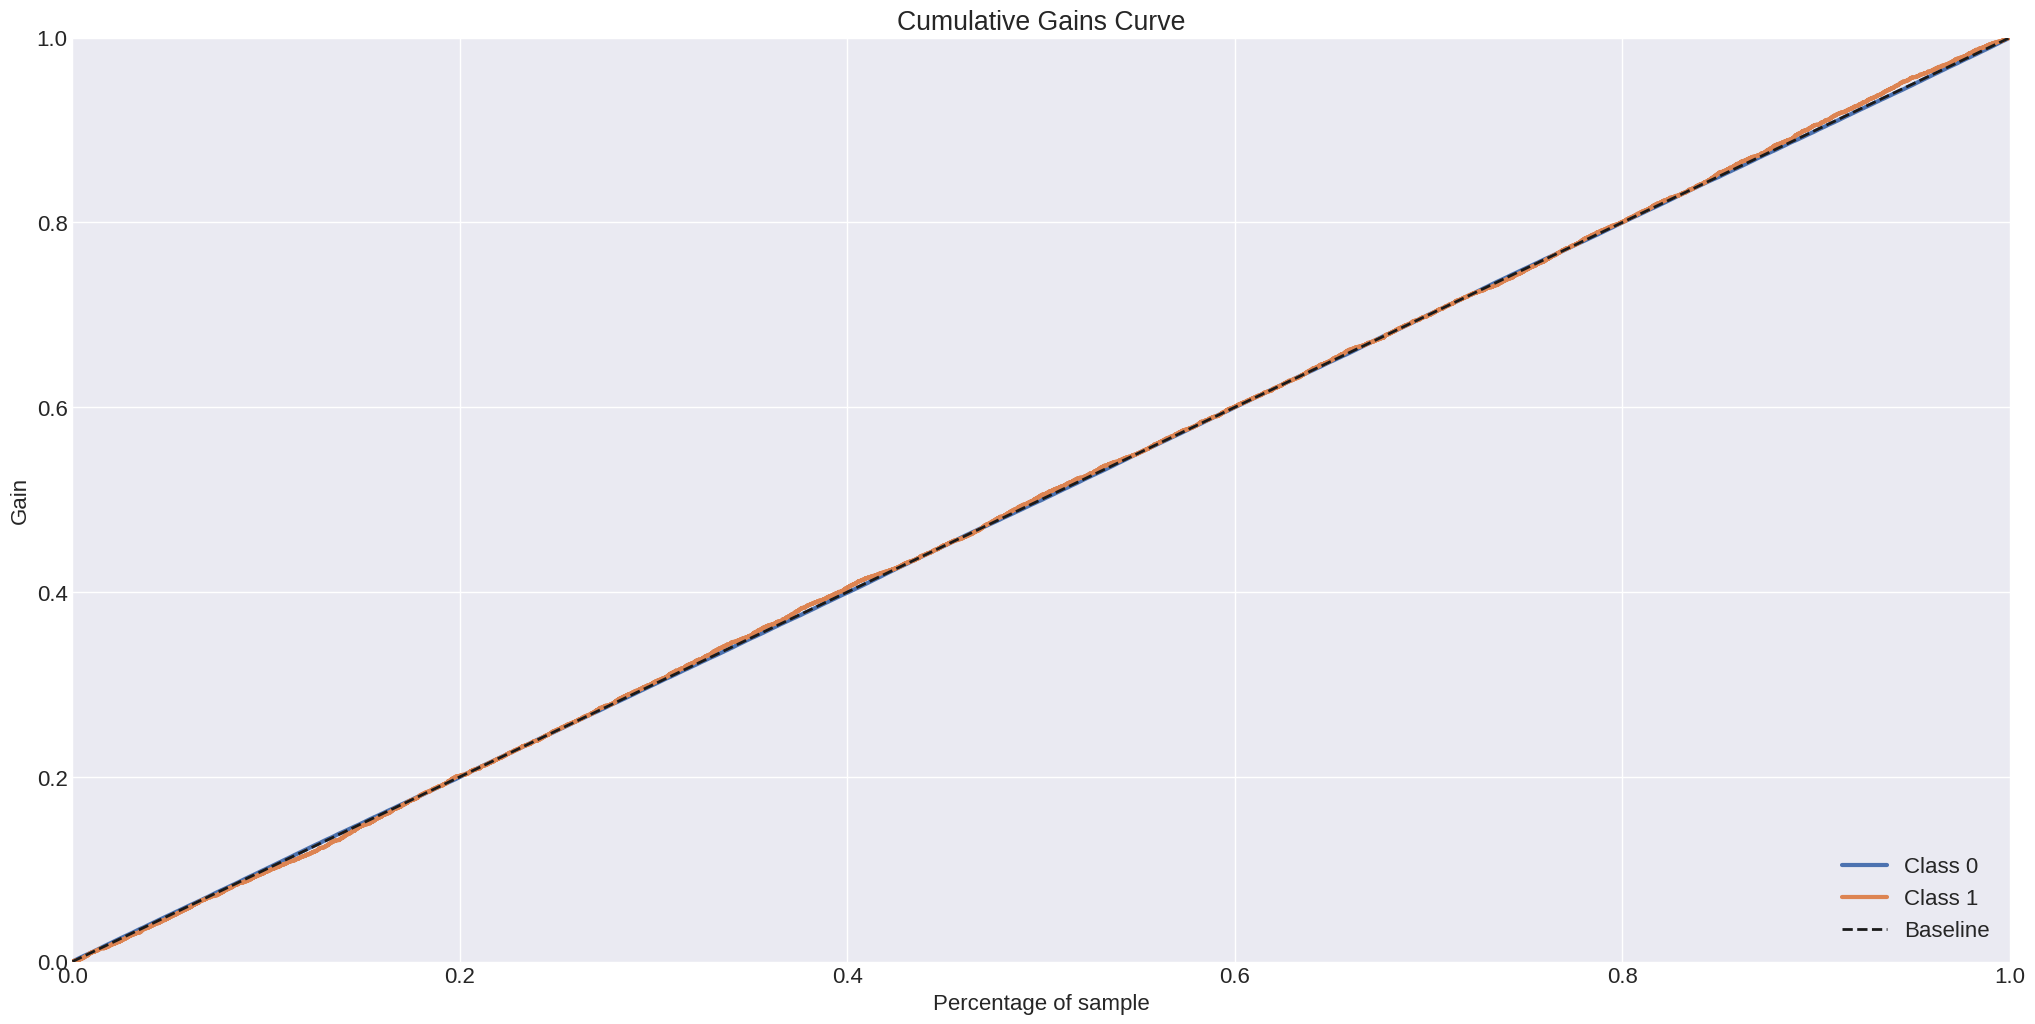

In [97]:

skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

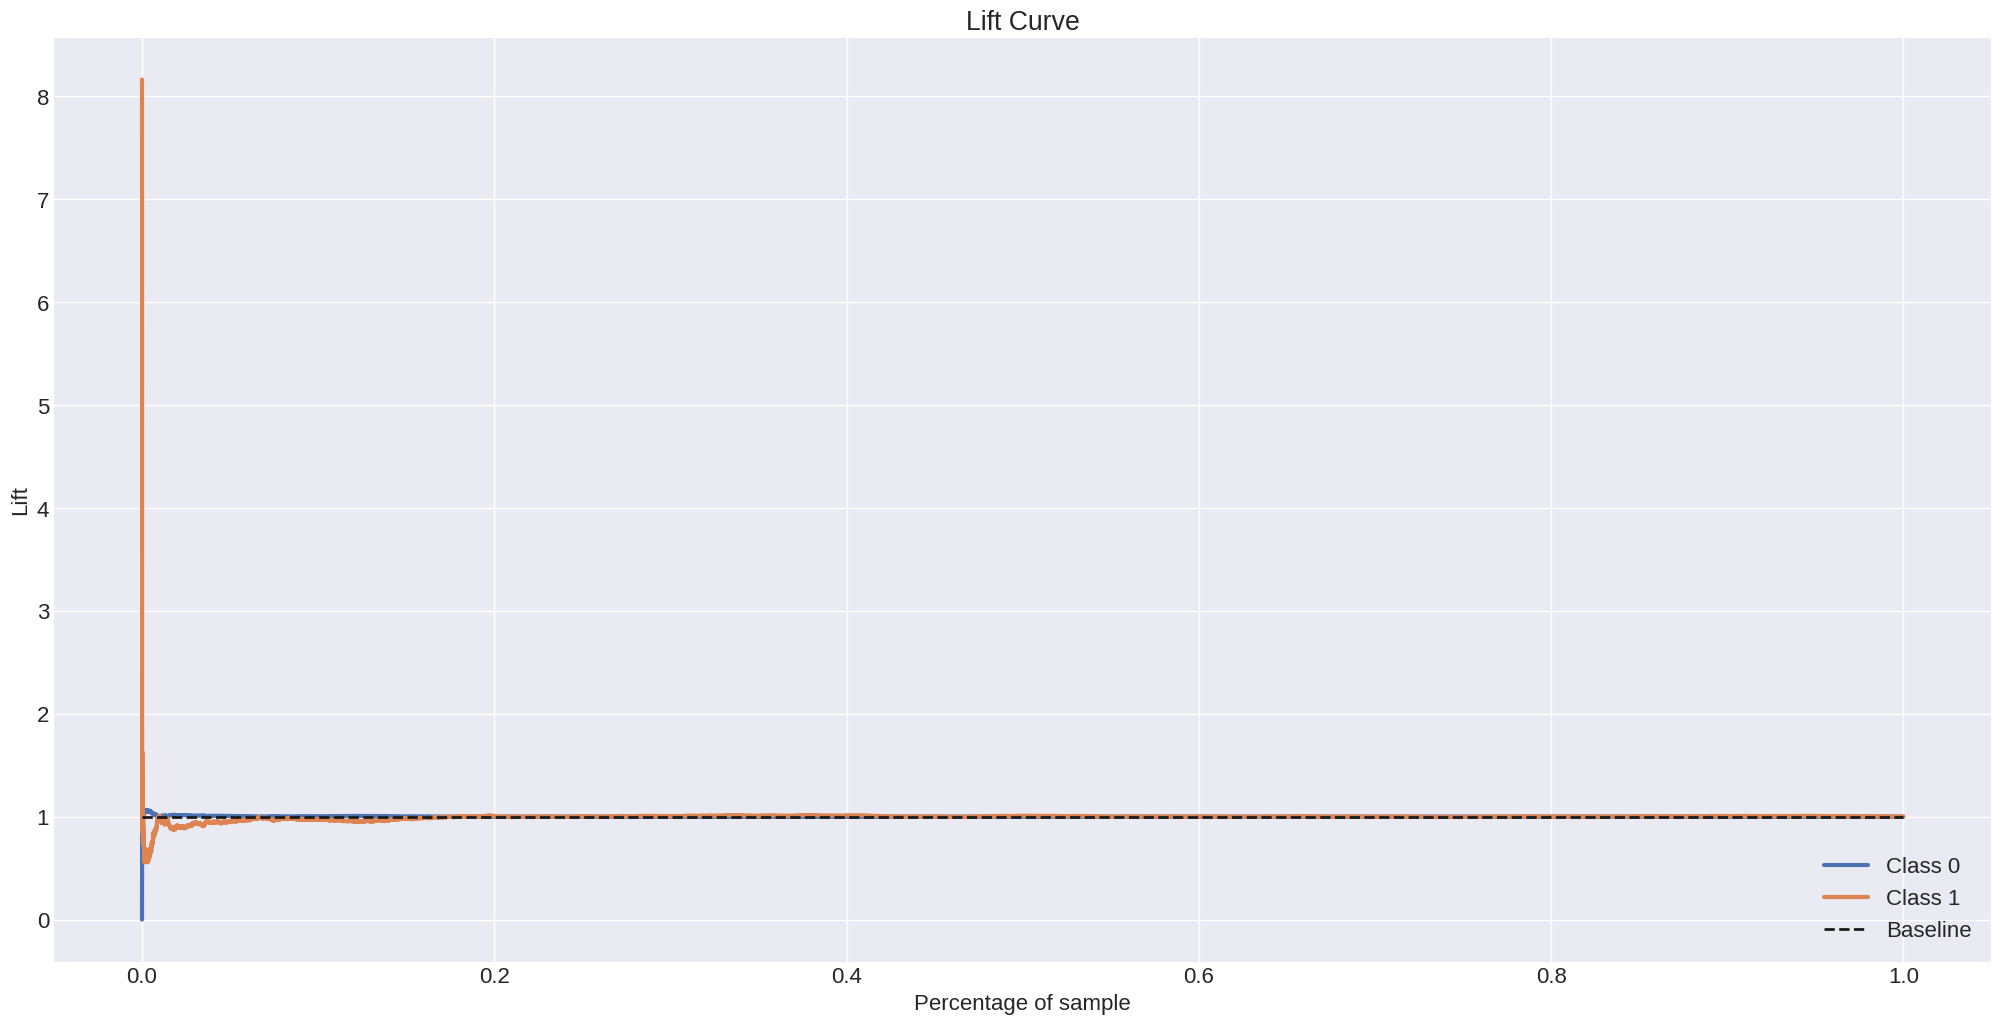

In [98]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

#### **7.2.2 Cross Validation**

In [99]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1231 +/- 0.0008,0.5021 +/- 0.0034,0.1977 +/- 0.0013


###**7.3 Logistic Regression**

In [100]:
lg = LogisticRegression(class_weight='balanced')
lg.fit(X_train, y_train)

y_prob = lg.predict_proba(X_valid)

In [101]:
k = int(y_valid.shape[0] / 2)

lg_results = ml_top_k_scores('Logistic Regression', y_valid, y_prob, k=k)
lg_results

,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression,0.2424,0.989,0.3894


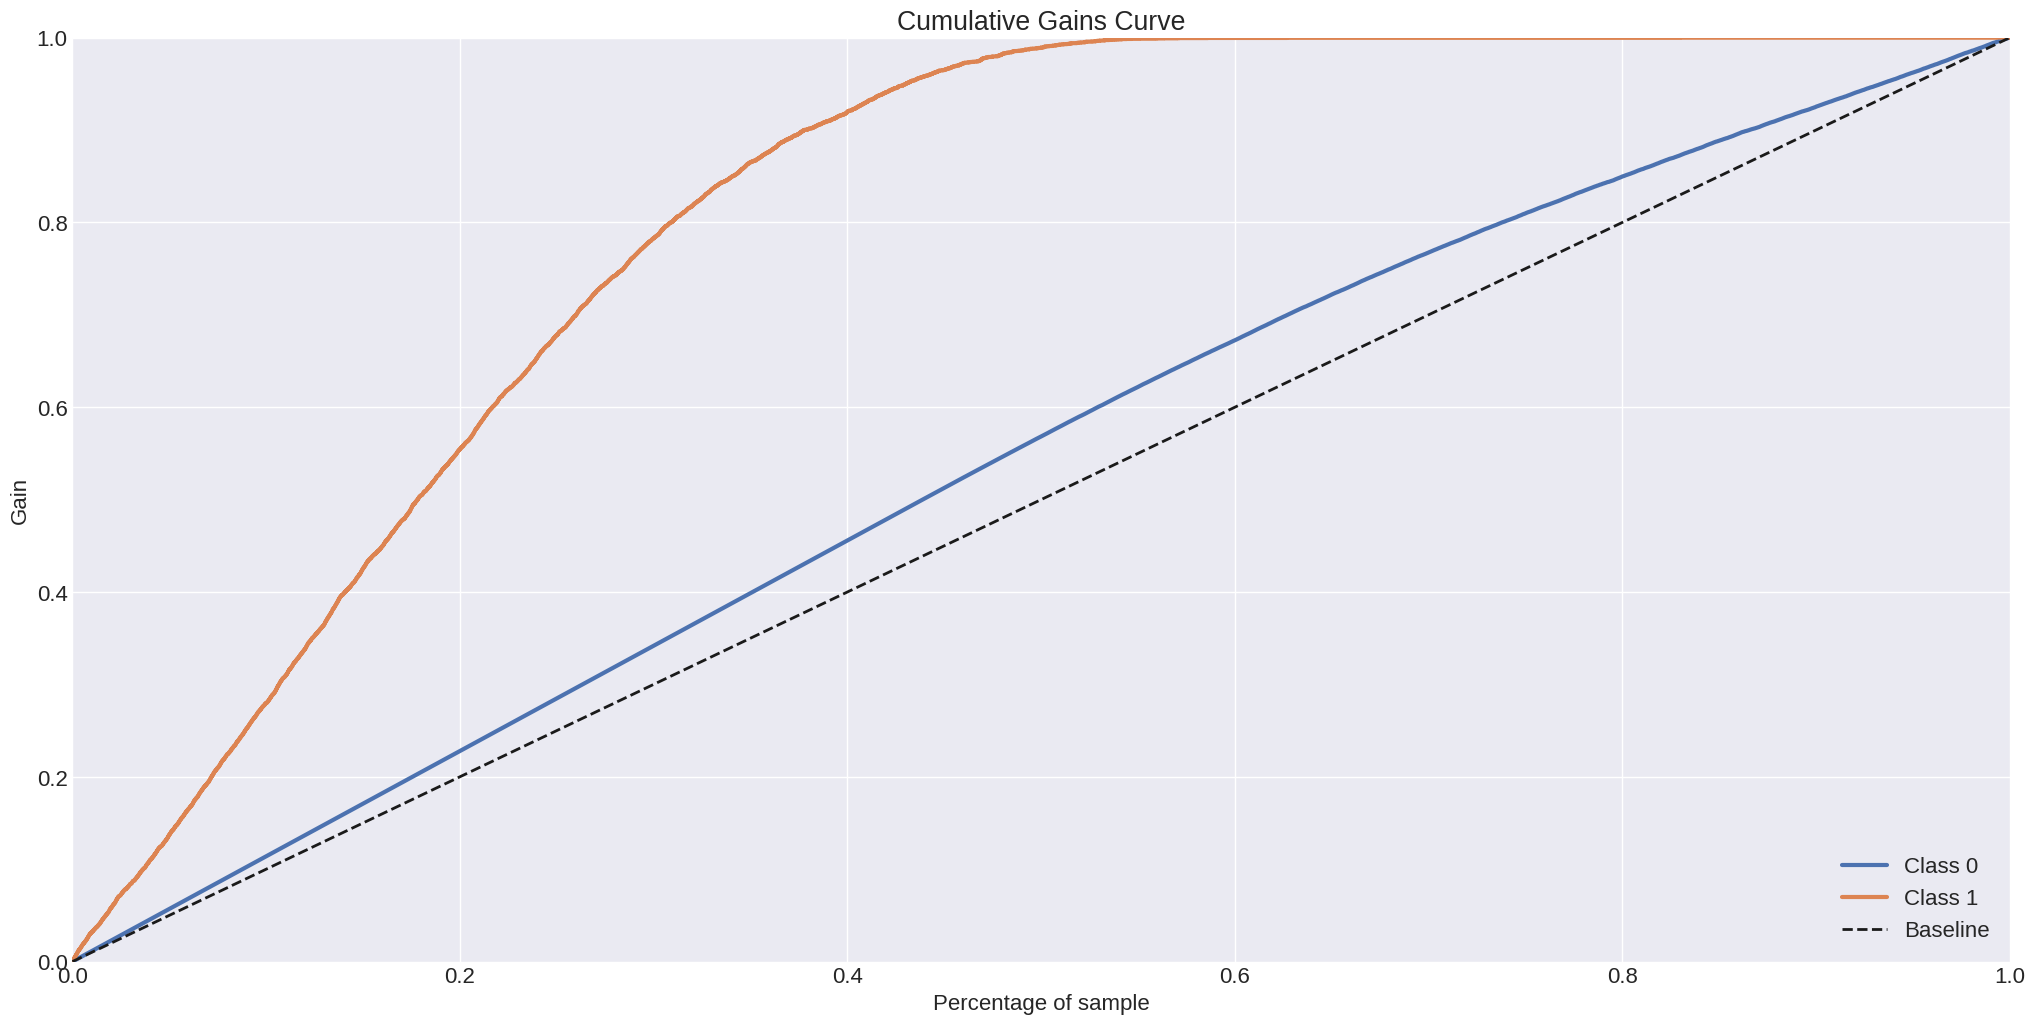

In [102]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

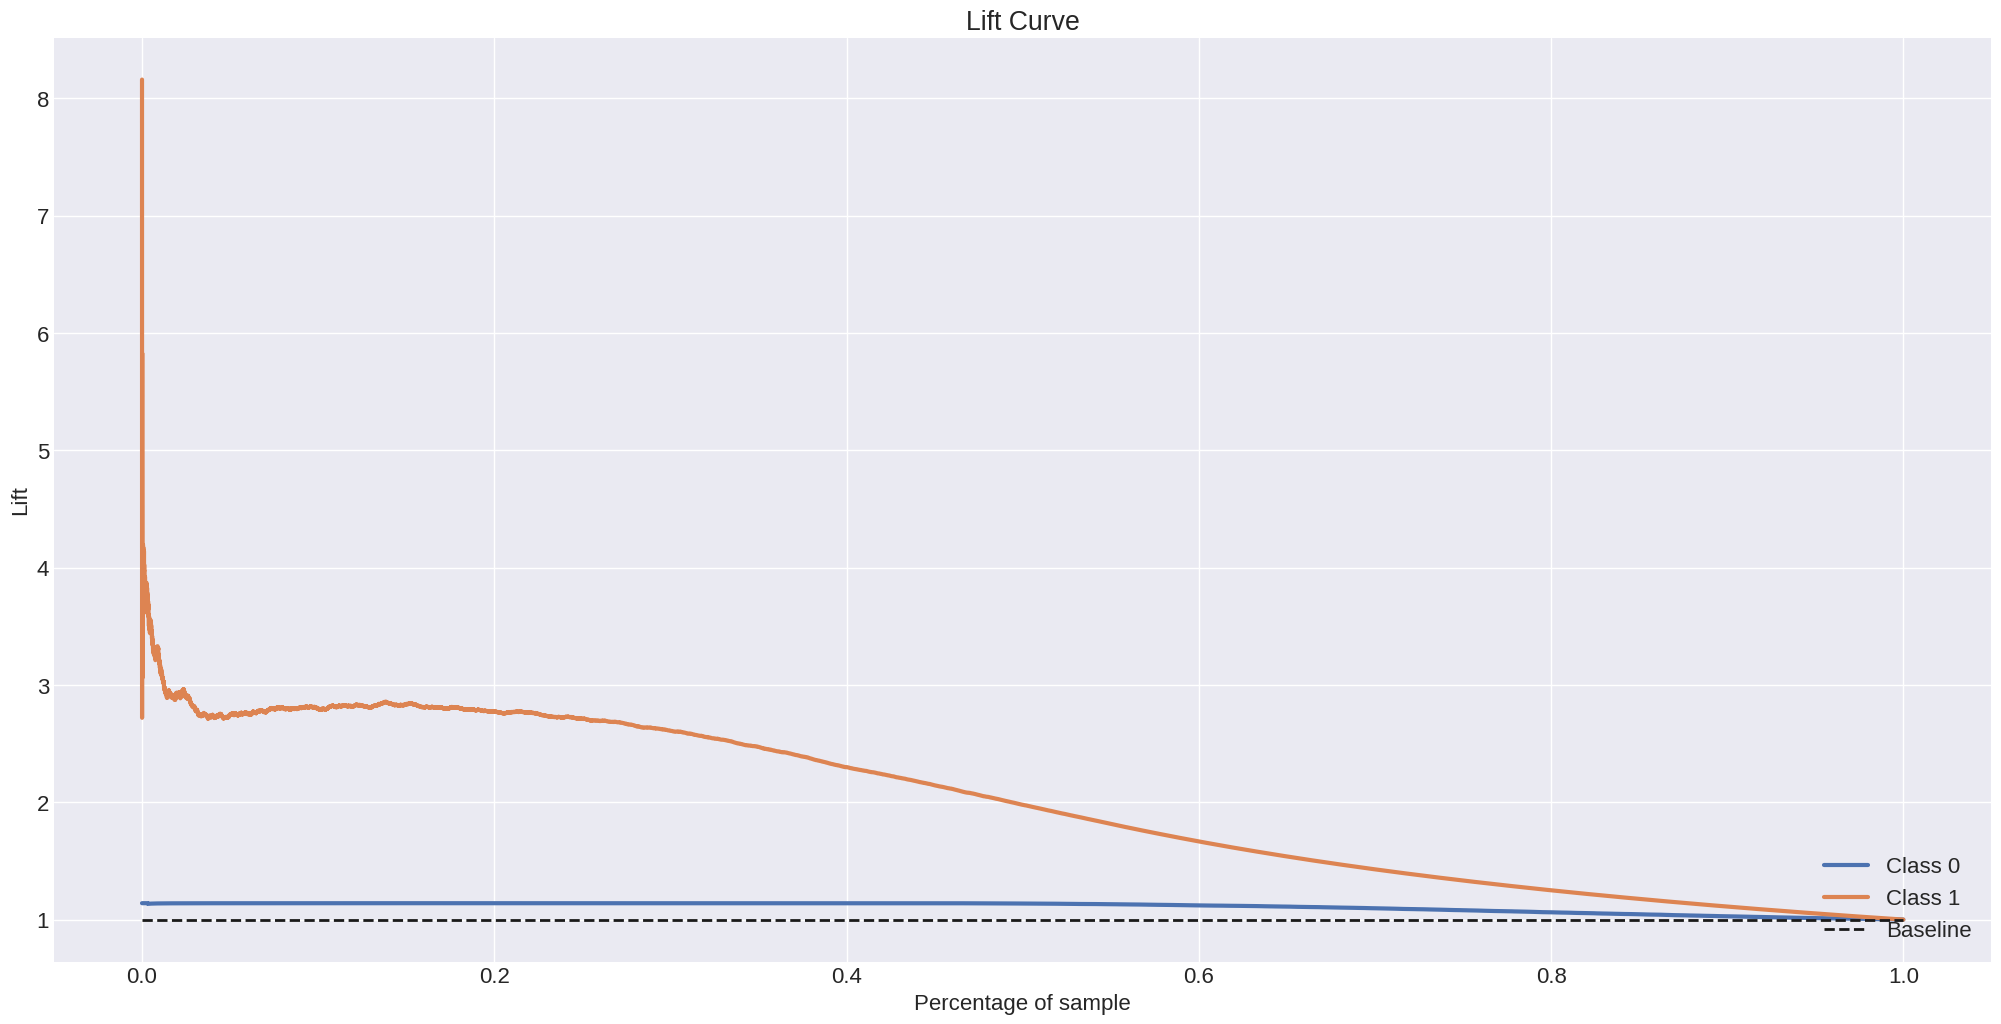

In [103]:
skplt.metrics.plot_lift_curve(y_valid, y_prob);

###**7.3.2 Cross Validation**

In [104]:

lg_cv = ml_cv_results('Logistic Regression', LogisticRegression(class_weight='balanced'), X_temp, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression,0.2421 +/- 0.0003,0.9877 +/- 0.0011,0.3889 +/- 0.0004


###**7.4 LightGBM**

In [105]:
lgbm = LGBMClassifier(class_weight='balanced')
lgbm.fit(X_train, y_train)

y_prob = lgbm.predict_proba(X_valid)


[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


#### **7.4.1 Results**

In [106]:

lgbm_results = ml_top_k_scores('LightGBM', y_valid, y_prob, k=k)
lgbm_results


,Precision_at_k,Recall_at_k,F1_at_k
LightGBM,0.2426,0.9898,0.3897


#### **7.4.2 Cross Validation**

In [107]:
lgbm_cv = ml_cv_results('LightGBM', LGBMClassifier(class_weight='balanced'), X_temp, y_temp)
lgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Fold K=2
[LightGBM] [Info] Number of positive: 29894, number of negative: 214015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 243909, number of used features: 7
[L

,Precision_at_k,Recall_at_k,F1_at_k
LightGBM,0.2419 +/- 0.0003,0.9868 +/- 0.0013,0.3885 +/- 0.0005


###**7.5 Comparing Model's Performance**
####**7.5.1 Single Performance**


In [108]:
modeling_performance = pd.concat([dummy_results, lg_results, lgbm_results])
modeling_performance.sort_values(by="Precision_at_k", ascending=True)

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1215,0.4956,0.1951
Logistic Regression,0.2424,0.9890,0.3894
LightGBM,0.2426,0.9898,0.3897


####**7.5.2 Cross Validation Performance**


In [109]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, lgbm_cv])
modeling_performance_cv.sort_values(by="Precision_at_k", ascending=True)

,Precision_at_k,Recall_at_k,F1_at_k
Dummy,0.1231 +/- 0.0008,0.5021 +/- 0.0034,0.1977 +/- 0.0013
LightGBM,0.2419 +/- 0.0003,0.9868 +/- 0.0013,0.3885 +/- 0.0005
Logistic Regression,0.2421 +/- 0.0003,0.9877 +/- 0.0011,0.3889 +/- 0.0004


 ## Hyperparameter Fine Tuning

In [110]:
df8_params = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_params_cycle1.csv')
df8_train = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_train_cycle1.csv')

df8_valid = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_valid_cycle1.csv')
df8_temp = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_temp_cycle1.csv')

In [111]:
X_params, y_params = df8_params.iloc[:, :-1], df8_params.iloc[:, -1]
X_train, y_train = df8_train.iloc[:, :-1], df8_train.iloc[:, -1]

X_valid, y_valid = df8_valid.iloc[:, :-1], df8_valid.iloc[:, -1]
X_temp, y_temp = df8_temp.iloc[:, :-1], df8_temp.iloc[:, -1]

In [112]:
f1 = mtr.make_scorer(mtr.recall_score)

In [113]:
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight': ['balanced'],
    'max_iter': [100, 500, 1000]
}

In [114]:
# lg_gs = GridSearchCV(
#     LogisticRegression(),
#     param_grid=params,
#     scoring=f1,
#     cv=StratifiedKFold(n_splits=5)
# )

# lg_gs.fit(X_params, y_params)


In [115]:

# best_params = lg_gs.best_params_
# best_params

In [116]:
best_params = {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100}


In [117]:
lg_gs = LogisticRegression(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    max_iter=best_params['max_iter']
)

lg_gs.fit(X_train, y_train)


LogisticRegression(C=0.001, class_weight='balanced')

In [118]:
y_prob = lg_gs.predict_proba(X_valid)

Results

In [119]:
k = int(0.5 * y_valid.shape[0])

lg_gs = ml_top_k_scores('Logistic Regression GS', y_valid, y_prob, k=k)
lg_gs


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression GS,0.2422,0.988,0.389


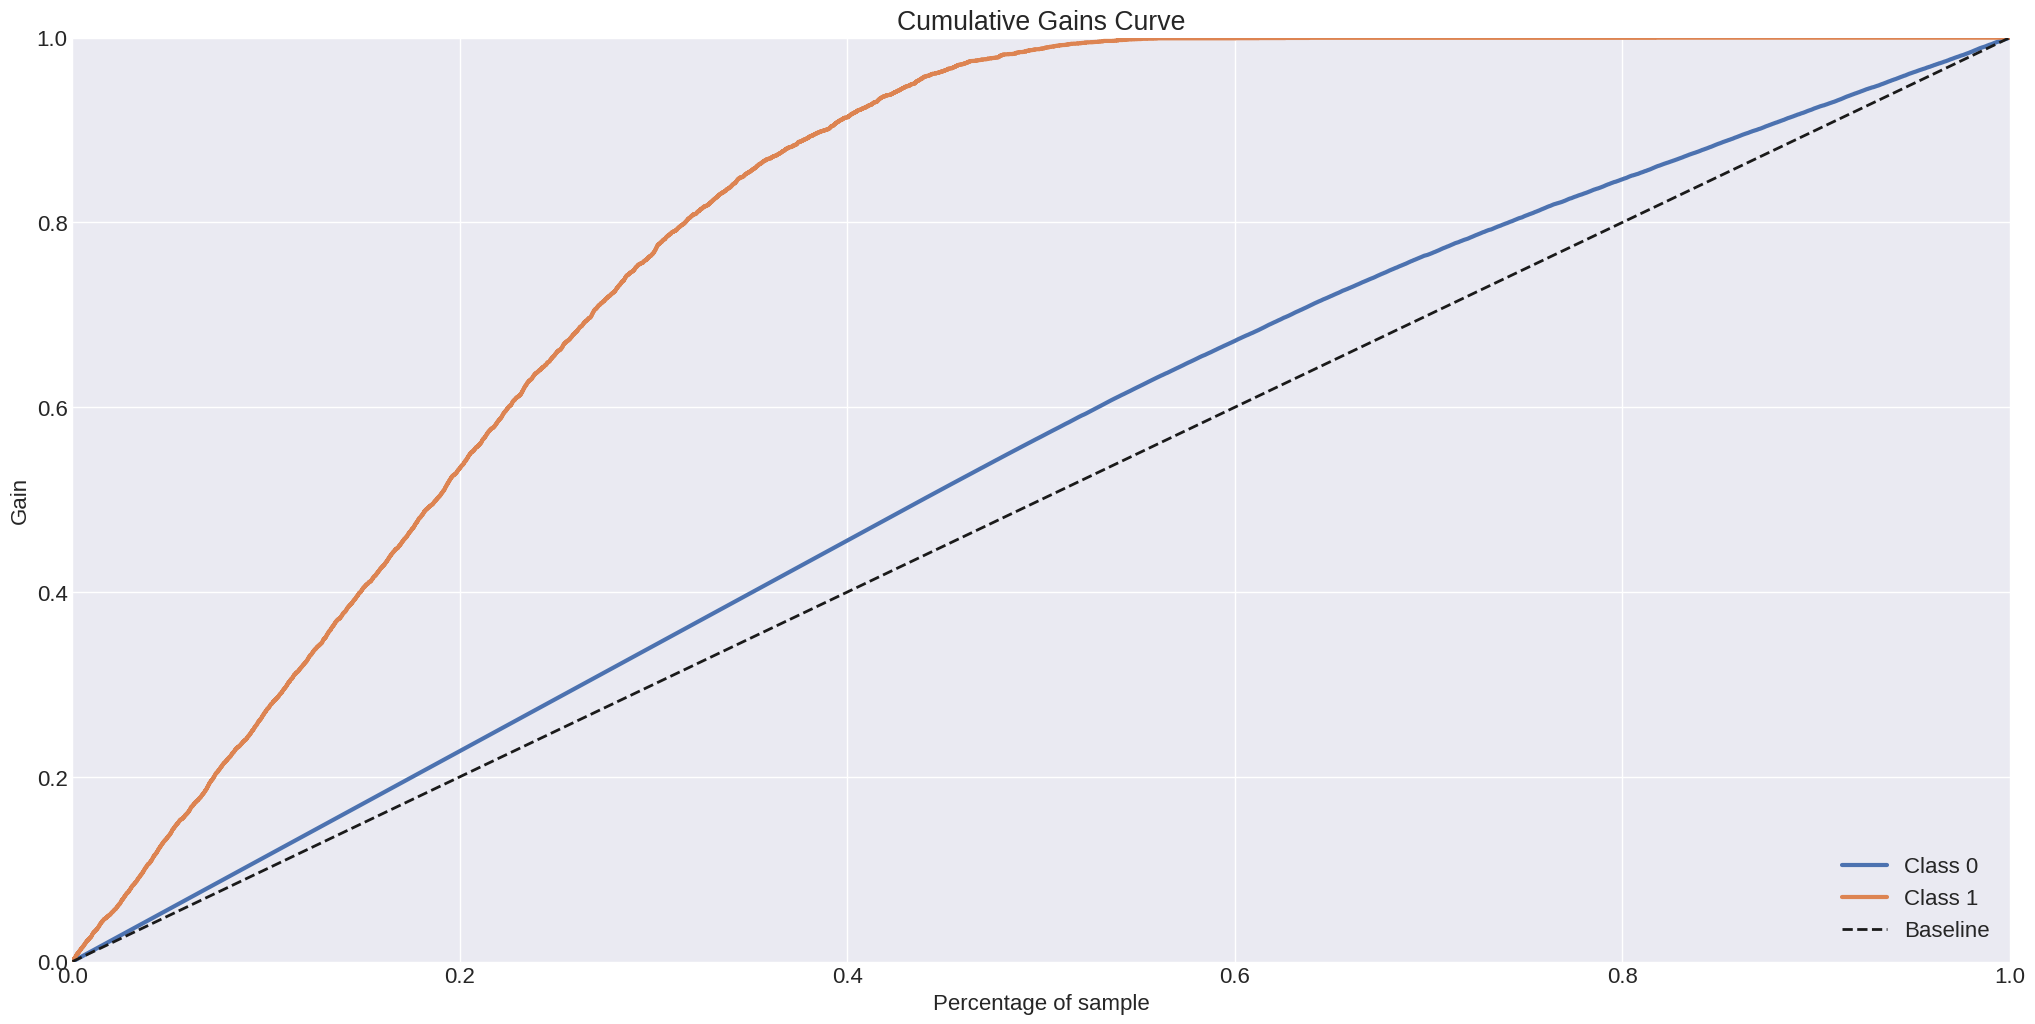

In [120]:
skplt.metrics.plot_cumulative_gain(y_valid, y_prob);

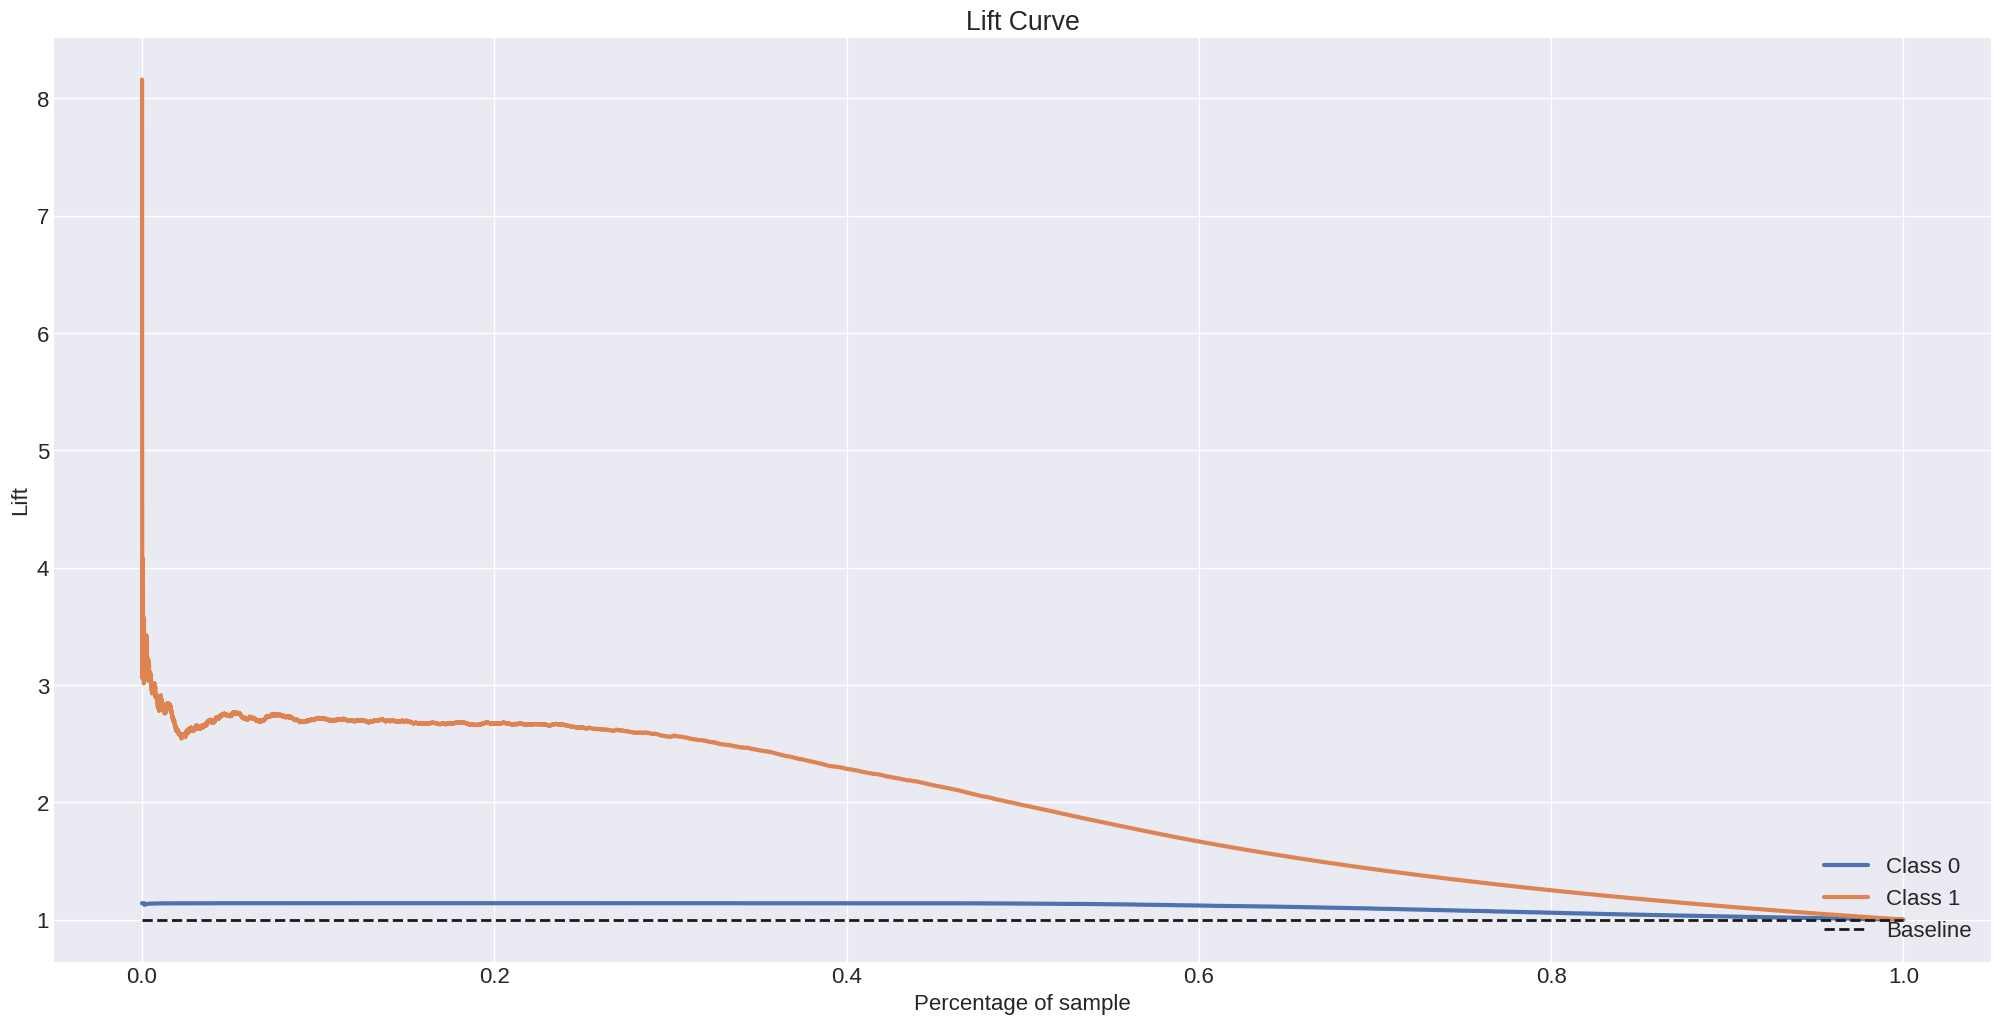

In [121]:

skplt.metrics.plot_lift_curve(y_valid, y_prob);

Cross Validation

In [122]:
lg_gs = LogisticRegression(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    max_iter=best_params['max_iter']
)

lg_gs_cv = ml_cv_results('Logistic Regression GS', lg_gs, X_temp, y_temp)
lg_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression GS,0.2411 +/- 0.0003,0.9834 +/- 0.0013,0.3872 +/- 0.0005


##**8.0 Conclusions**
###**8.1 Loading**

In [123]:

df4 = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step03_cycle1.csv')

df9_params = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_params_cycle1.csv')
df9_test = pd.read_csv('/content/drive/MyDrive/cross_sell/data_step06_test_cycle1.csv')


In [124]:

X_params, y_params = df9_params.iloc[:, :-1], df9_params.iloc[:, -1]
X_test, y_test = df9_test.iloc[:, :-1], df9_test.iloc[:, -1]


###**8.2 Final Model**

In [125]:
final_model = LogisticRegression(C = best_params['C'],
                                 class_weight=best_params['class_weight'],
                                 max_iter = best_params['max_iter'])
final_model.fit(X_params, y_params)

LogisticRegression(C=0.001, class_weight='balanced')

####**8.2.1 Unseen Data Result**

In [126]:

y_prob = final_model.predict_proba(X_test)

In [127]:

final_model_score = ml_top_k_scores('Logistic Regression GS', y_test, y_prob, k=k)
final_model_score


,Precision_at_k,Recall_at_k,F1_at_k
Logistic Regression GS,0.2804,0.9151,0.4293


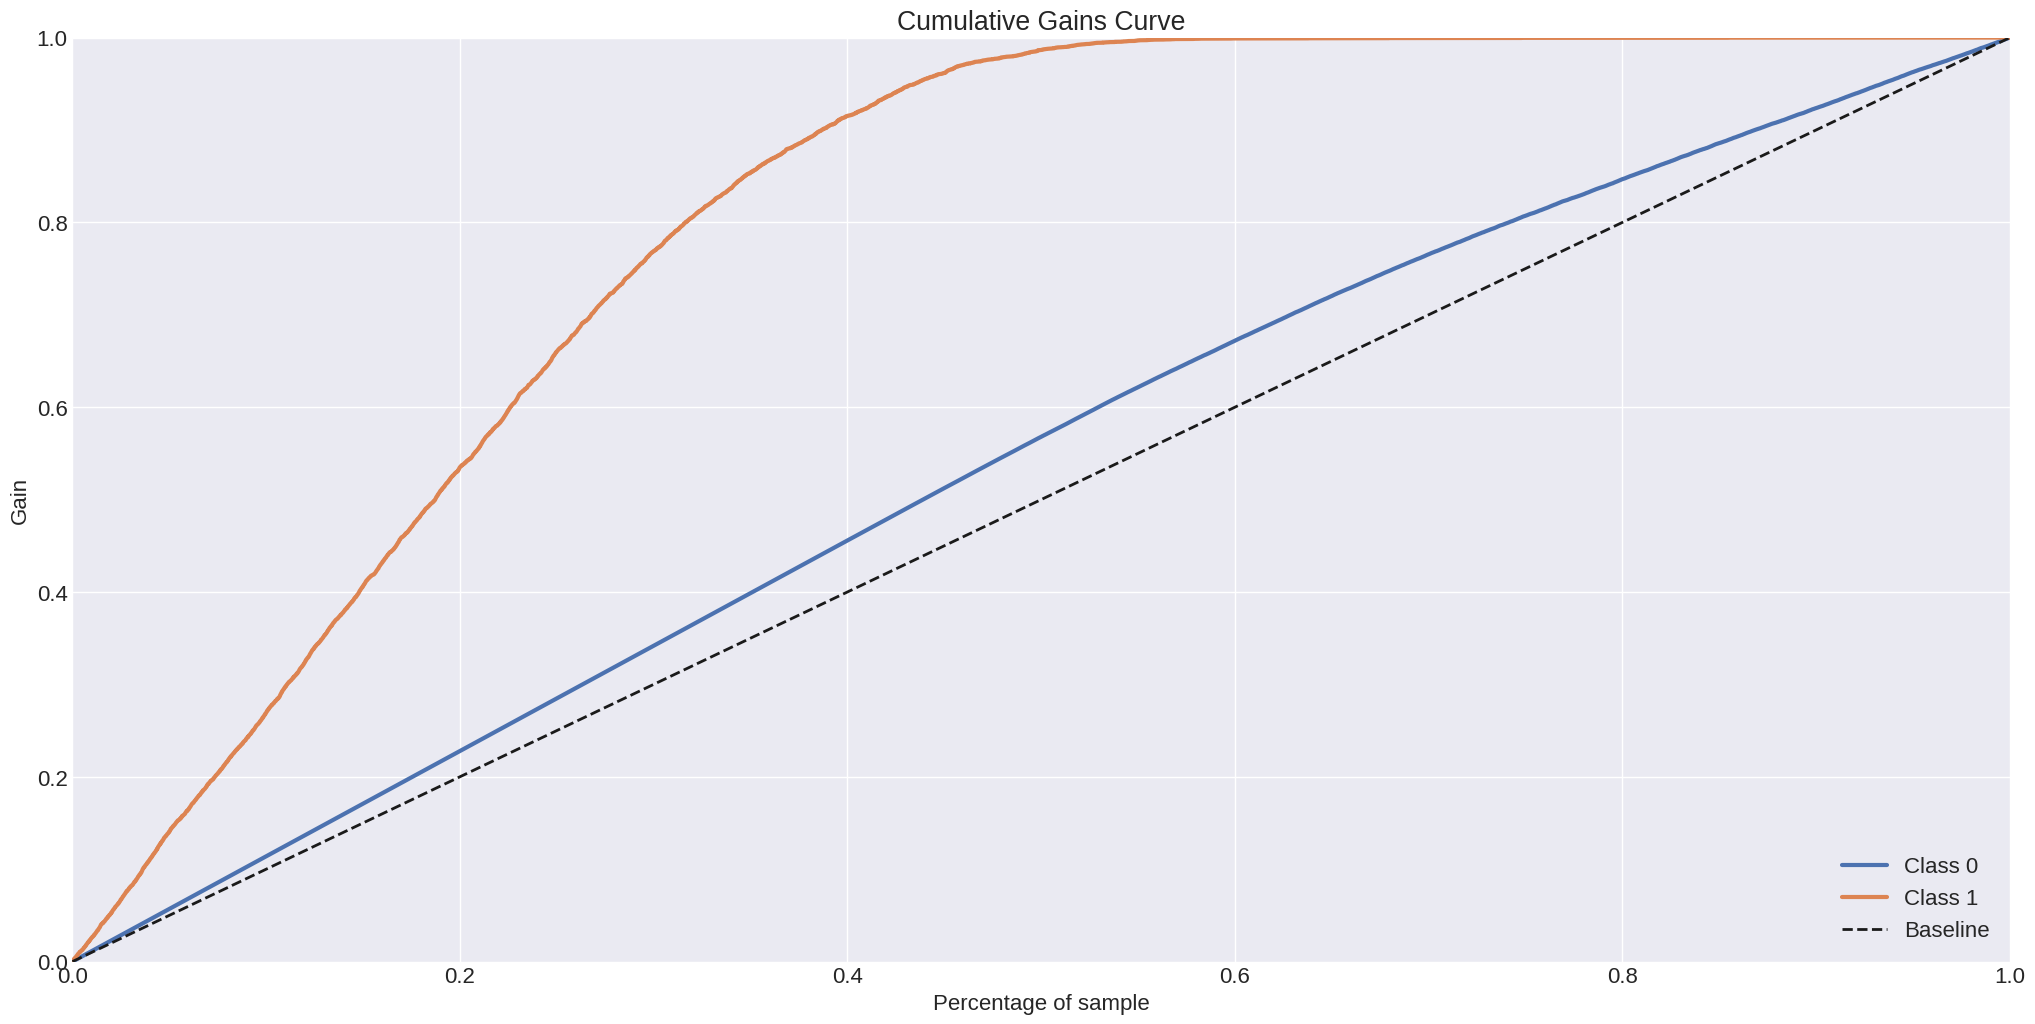

In [128]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob);


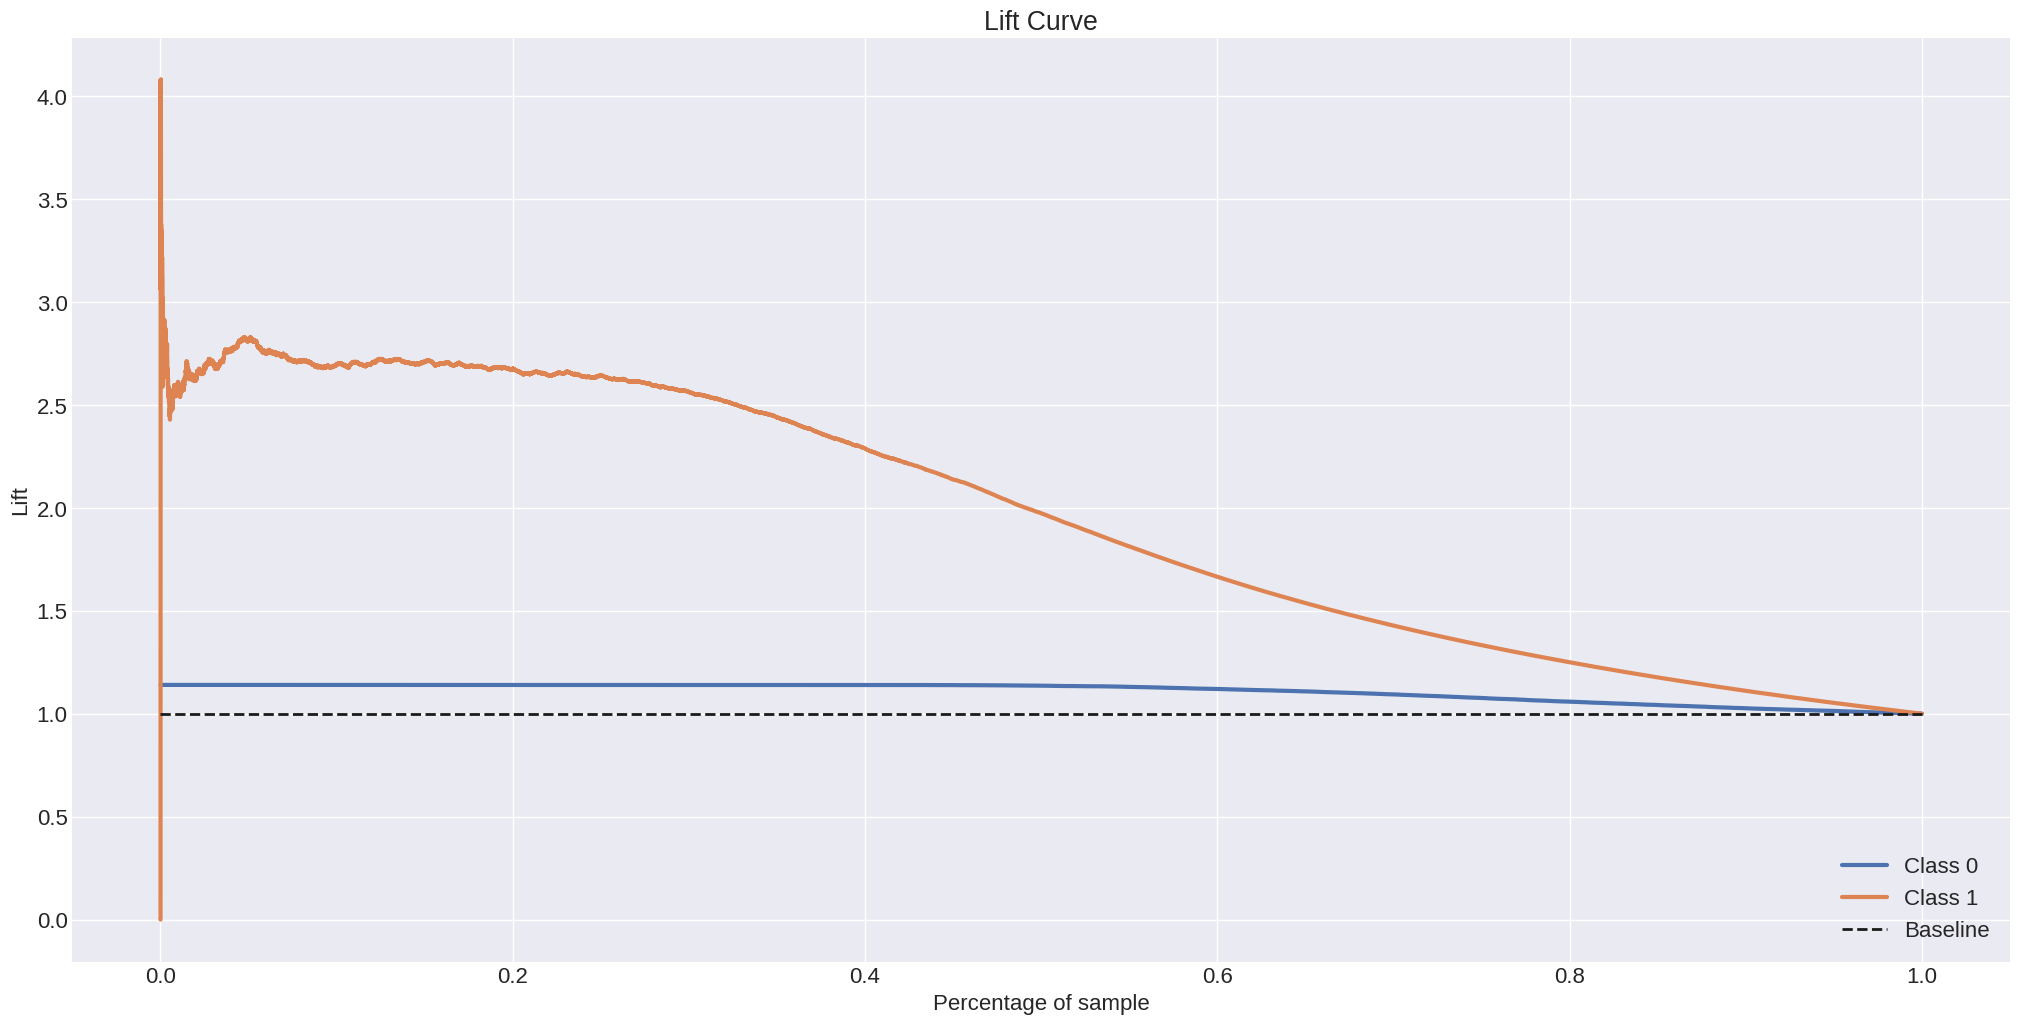

In [129]:
skplt.metrics.plot_lift_curve(y_test, y_prob);

In [130]:
joblib.dump(final_model,'/content/drive/MyDrive/cross_sell/logistict_regression.joblib')

['/content/drive/MyDrive/cross_sell/logistict_regression.joblib']

###**8.3 Business Questions**
####**8.3.1 What are the main insights on the most relevant attributes of relevant customers in purchasing auto insurance**

**Early Aulthood and adolescent are about 26.1% of the cutomer who want the vehicle insurance. The midlife customers are more likely to get insurance, they are about 48.3%**

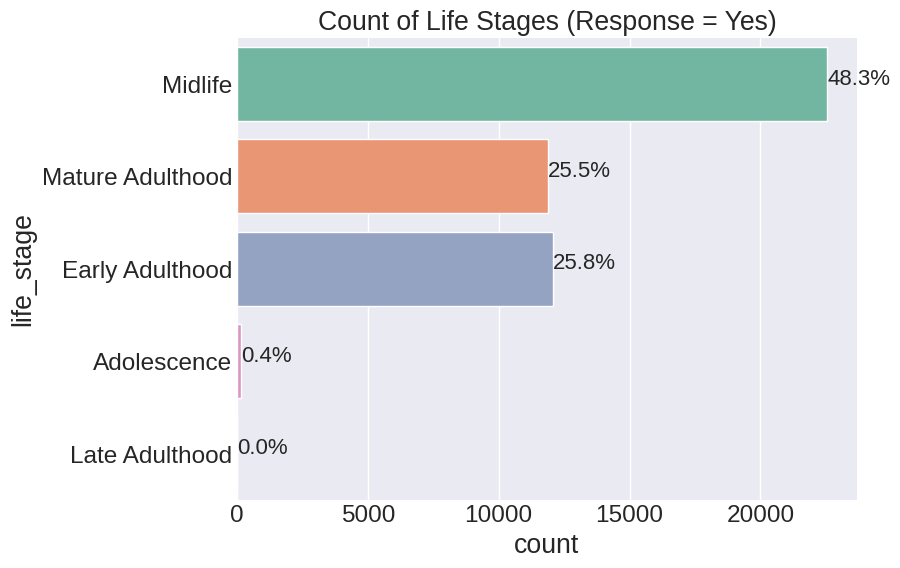

In [131]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='life_stage',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['life_stage'].nunique())
)

total = aux1['Gender'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Life Stages (Response = Yes)")
plt.show()

* **There is a significant relationship between having health insrance and the likelihood of purchasing vehicle insrance , but not as we think: customers with health insurance are more likely to buy vehicle insurance. It seems that when customers have previously purchased health insurance, they are less inclined to buy vehicle insurance. The probability that a person who previously purchased health insurance will buy vehicle insurance is only 0.09%**
* **97.9% of customers who are interested in purchasing vehicle insurance had previously experienced vehicle damage.**



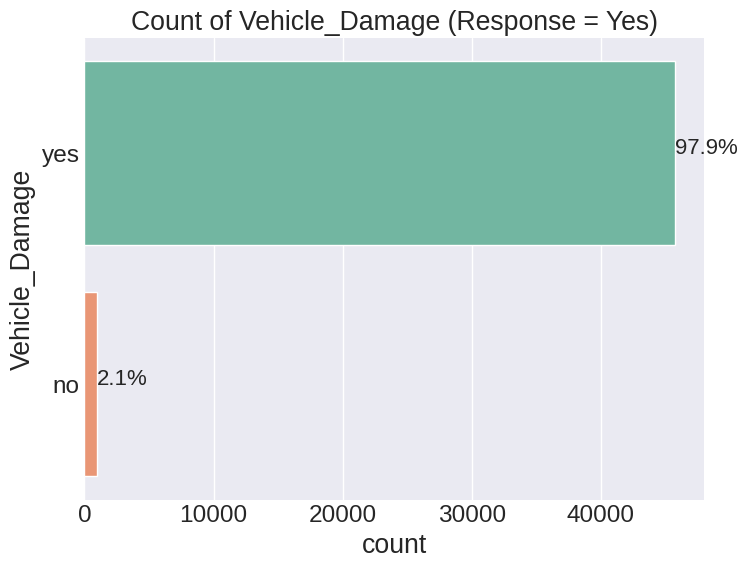

In [132]:
aux1= df4[df4['Response']=='yes']

plt.figure(figsize=(8, 6))
ax = sns.countplot(
    y='Vehicle_Damage',
    data=aux1,
    palette=sns.color_palette("Set2", n_colors=aux1['Vehicle_Damage'].nunique())
)

total = aux1['Vehicle_Damage'].size
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

plt.title("Count of Vehicle_Damage (Response = Yes)")
plt.show()

####**8.3.2 What percentage of customers are interested in purchasing auto insurance? Will the sales team be able to reach them by making 20,000 calls**

In [133]:
print(df5['Response'].count())
print(df5['Response'].value_counts())
print(df5['Response'].value_counts()/df5['Response'].count())


381109
no     334399
yes     46710
Name: Response, dtype: int64
no     0.877437
yes    0.122563
Name: Response, dtype: float64


In [134]:
print(0.2411*20000)
print(0.2411*40000)

4822.0
9644.0


1. The database is based on 46,876 (12.3%) of customers interessed in health insurance and 334,232 (87.7%) of no interested.
2. The model results have shown that the model has the precision of 24.11% (24.14% for a excellent performance or 24.06% for a poor performance). So, using the model it's possible to contact 4,822 (4,828 for a excellent performance or 4,812 for a poor performance) customers interested in health insurance of 20,000 calls. However the recall is about 98.34% (+/- 0.0013).

####**8.3.3 If the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?**
####Increasing to 40,000 calls the model may help the sales team to contact 9,644 (9,660 for a excellent performance or 9,620 for a poor performance) the customers interested in health insurance.

####**8.3.4  How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?**

The model sorted 98.31% (46,084 customers) of the customer interested in 50% of the database with 381,109 customers. Using the model, it's possible to contact 80% of customers interested in health insurance in 155,064 (155,064 for a excellent performance or 155,064 for a poor performance) calls.